# 1. Introduction

Nikki Satmaka - Batch 11

## Description

Dataset is taken from [Google Cloud Platform ftds-hacktiv8](https://console.cloud.google.com/bigquery?p=ftds-hacktiv8-project&d=phase1_assignments&t=credit-card-information&page=table)


Context:

This dataset contains 
1. `CUST_ID` : Identification of Credit Card holder
2. `BALANCE` : Balance amount left in their account to make purchases
3. `BALANCE_FREQUENCY` : How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)
4. `PURCHASES` : Amount of purchases made from account
5. `ONEOFF_PURCHASES` : Maximum purchase amount done in one-go
6. `INSTALLMENTS_PURCHASES` : Amount of purchase done in installment
7. `CASH_ADVANCE` : Cash in advance given by the user
8. `PURCHASES_FREQUENCY` : How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased)
9. `ONEOFF_PURCHASES_FREQUENCY` : How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased)
10. `PURCHASES_INSTALLMENTS_FREQUENCY` : How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)
11. `CASH_ADVANCE_FREQUENCY` : How frequently the cash in advance being paid
12. `CASH_ADVANCE_TRX` : Number of Transactions made with 'Cash in Advanced'
13. `PURCHASES_TRX` : Numbe of purchase transactions made
14. `CREDIT_LIMIT` : Limit of Credit Card for user
15. `PAYMENTS` : Amount of Payment done by user
16. `MINIMUM_PAYMENTS` : Minimum amount of payments made by user
17. `PRC_FULL_PAYMENT` : Percent of full payment paid by user
18. `TENURE` : Tenure of credit card service for user


### Objective

- To create a clustering model to find Customer Segmentation



### Problem Statement

- How many clusters should we divide the dataset into?

### Data Collection

We first need to query our data from GCP's BiqQuery using this code

```SQL
SELECT *
FROM `ftds-hacktiv8-project.phase1_assignments.credit-card-information`
WHERE MOD(CUST_ID, 2) != 0
```

# 2. Importing Libraries

In [1]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

import joblib

import warnings
warnings.filterwarnings('ignore')

# For Handling outlier
from feature_engine.outliers import OutlierTrimmer
from feature_engine.outliers import Winsorizer

# For Feature Engineering
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA

# For Data Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# For Clustering Problems
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture

# Split Dataset and Standarize the Datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler

# Evaluate Clustering Algorithms
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

pd.set_option('display.precision', 2)

sns.set_theme(style='darkgrid', palette='deep')

%matplotlib inline

### Useful Functions

In [2]:
def check_unique(data, col_type='both'):
    """
    Count the number of unique values in each features for 'numeric', 'categorical', or 'both'

    Parameters
    ----------
    data : DataFrame

    col_type : str
        The type of the column to filter. Either 'number', 'object', or 'both'

    Returns
    -------
    DataFrame
        Number of unique values of each features
    """

    # check if the column type is valid
    if col_type not in ('number', 'object', 'both'):
        raise ValueError('col_type must be either "number", "object", or "both"')

    # create a list if the column type is 'both'
    if col_type == 'both':
        col_type = ['number', 'object']

    # get the number of unique values in each column
    data_unique_count = pd.DataFrame.from_records(
        [(col, data[col].nunique()) for col in data.select_dtypes(include=col_type).columns],
        columns=['feats', 'num_unique']
    )
    data_unique_count['pct_unique'] = data_unique_count['num_unique'] / data.shape[0] * 100

    return data_unique_count

In [3]:
def check_missing(data):
    """
    Check the missing values in dataset

    Parameters
    ----------
    data : DataFrame

    Returns
    -------
    DataFrame
        Missing values in dataset
    """

    # create a DataFrame to store the missing values
    data_missing = pd.DataFrame(data.isna().sum().sort_values(ascending=False), columns=['tot_missing']).reset_index()

    # reset the index and make the features columns
    data_missing = data_missing.rename(columns={'index': 'feats'})

    # drop the rows with no missing values
    data_missing = data_missing[data_missing['tot_missing'] > 0]

    # calculate the percentage of missing values for each features
    data_missing['tot_missing_pct'] = data_missing['tot_missing'] / len(data) * 100

    return data_missing

In [4]:
def find_normal_boundaries(data, variable):
    """
    Calculate the boundaries outside which sit the outliers for a Gaussian distribution

    Parameters
    ----------
    data : DataFrame

    variable : string
        The feature of the DataFrame in which to the calculation will be performed

    Returns
    -------
    upper_boundary : float
        The computed upper boundary of the data

    lower_boundary : float
        The computed lower boundary of the data
    """

    upper_boundary = data[variable].mean() + 3 * data[variable].std()
    lower_boundary = data[variable].mean() - 3 * data[variable].std()

    return upper_boundary, lower_boundary

In [5]:
def find_skewed_boundaries(data, variable, distance):
    """
    Calculate the boundaries outside which sit the outliers for skewed distribution

    Parameters
    ----------
    data : DataFrame

    variable : string
        The feature of the DataFrame in which to the calculation will be performed

    distance : float
        The distance multiplier of IQR to calculate the boundaries

    Returns
    -------
    upper_boundary : float
        The computed upper boundary of the data

    lower_boundary : float
        The computed lower boundary of the data
    """

    IQR = data[variable].quantile(0.75) - data[variable].quantile(0.25)

    upper_boundary = data[variable].quantile(0.75) + (IQR * distance)
    lower_boundary = data[variable].quantile(0.25) - (IQR * distance)

    return upper_boundary, lower_boundary

In [6]:
def check_dist(data):
    """
    Check the Skewness and Distribution for each features in a dataset

    Parameters
    ----------
    data : DataFrame

    Returns
    -------
    DataFrame
        Skewness and distribution types of each features
    """

    # create a DataFrame containing the features of the dataset and their respective skewness
    data_skewness = pd.DataFrame(data.skew(), columns=['skew']).reset_index()

    # reset the index and make the features columns
    data_skewness = data_skewness.rename(columns={'index': 'feats'})

    # create a new column to describe whether the feature in the dataset is normal or skewed
    data_skewness['dist'] = np.where(
        (data_skewness['skew'] > -0.5) & (data_skewness['skew'] < 0.5),
        'normal',
        'skewed'
    )

    return data_skewness

In [7]:
def check_outlier(data, distance=1.5):
    """
    Check the outlier info for each features in a dataset

    Parameters
    ----------
    data : DataFrame

    distance : float
        The distance multiplier of IQR to calculate the boundaries for skewed distributions. It's either 1.5 or 3

    Returns
    -------
    DataFrame
        Outlier infos such as upper and lower boundary, and also the number of outliers for each features
    """

    if distance not in (1.5, 3):
        raise ValueError('Parameter distance only accepts numeric value of either 1.5 or 3')

    data_skewness = check_dist(data)

    # create a dictionary to store the outlier infos
    data_outlier = {
        'feats': [],
        'upper_bound': [],
        'lower_bound': [],
        'tot_right_tail': [],
        'tot_left_tail': [],
        'tot_right_tail_pct': [],
        'tot_left_tail_pct': [],
        'tot_outlier': [],
        'tot_outlier_pct': [],
    }

    # loop over each row in the `skewness` DataFrame
    # calculate each features upper and lower boundaries and the outlier percentage
    for row in data_skewness.index:
        col = data_skewness.iloc[row]['feats']

        if data_skewness.iloc[row]['dist'] == 'normal':
            upper_bound, lower_bound = find_normal_boundaries(data, col)
        else:
            upper_bound, lower_bound = find_skewed_boundaries(data, col, distance)

        tot_right_tail = len(data[data[col] > upper_bound])
        tot_left_tail = len(data[data[col] < lower_bound])
        tot_right_tail_pct = tot_right_tail / len(data) * 100
        tot_left_tail_pct = tot_left_tail / len(data) * 100
        tot_outlier =  tot_right_tail + tot_left_tail
        tot_outlier_pct = tot_right_tail_pct + tot_left_tail_pct

        data_outlier['feats'].append(col)
        data_outlier['upper_bound'].append(upper_bound)
        data_outlier['lower_bound'].append(lower_bound)
        data_outlier['tot_right_tail'].append(tot_right_tail)
        data_outlier['tot_left_tail'].append(tot_left_tail)
        data_outlier['tot_right_tail_pct'].append(tot_right_tail_pct)
        data_outlier['tot_left_tail_pct'].append(tot_left_tail_pct)
        data_outlier['tot_outlier'].append(tot_outlier)
        data_outlier['tot_outlier_pct'].append(tot_outlier_pct)
    
    data_outlier = pd.DataFrame(data_outlier)

    return data_outlier

In [8]:
def outlier_summary(data, distance=1.5):
    """
    Check the summary for outlier data, such as distribution and number of outliers for each features

    Parameters
    ----------
    data : DataFrame

    distance : float
        The distance multiplier of IQR to calculate the boundaries for skewed distributions. It's either 1.5 or 3

    Returns
    -------
    DataFrame
        Summary of outlier such as distribution and number of outliers for each features
    """

    data_skewness = check_dist(data)
    data_outlier = check_outlier(data, distance)

    outlier_summary_cols = ['feats', 'skew', 'dist', 'tot_outlier', 'tot_outlier_pct']

    data_outlier_summary = pd.merge(data_skewness, data_outlier, on=['feats'])
    data_outlier_summary = data_outlier_summary[outlier_summary_cols]

    return data_outlier_summary

In [9]:
def trim_cap_outliers(data, exception_list=[], target=None, distance=1.5):
    """
    Function to trim outliers based on the cap outliers

    Parameters
    ----------
    data : pandas DataFrame
        DataFrame to trim outliers
    exception_list : list
        List of features to be excluded from trimming
    target : pandas Series or DataFrame
        Target variable name
    distance : float
        Distance multiplier to define the cap

    Returns
    -------
    data : pandas DataFrame
        Trimmed data
    if target is not None:
        target : pandas Series or DataFrame
            Trimmed target variable
    """

    # define whether to adjust target
    adjust_target = False
    if target is not None:
        adjust_target = True

    # run outlier detection
    data_outlier = outlier_summary(data, distance)

    # create a list of columns to trim outliers for normal distribution
    norm_trim_cols = data_outlier[
        (data_outlier['dist'] == 'normal') &
        (data_outlier['tot_outlier_pct'] < 5)
    ]['feats'].to_list()

    # create a list of columns to cap outliers for normal distribution
    norm_cap_cols = data_outlier[
        (data_outlier['dist'] == 'normal') &
        (data_outlier['tot_outlier_pct'] >= 5) &
        (data_outlier['tot_outlier_pct'] < 15)
    ]['feats'].to_list()

    # create a list of columns to trim outliers for skew distribution
    skew_trim_cols = data_outlier[
        (data_outlier['dist'] == 'skewed') &
        (data_outlier['tot_outlier_pct'] < 5)
    ]['feats'].to_list()

    # create a list of columns to cap outliers for skew distribution
    skew_cap_cols = data_outlier[
        (data_outlier['dist'] == 'skewed') &
        (data_outlier['tot_outlier_pct'] >= 5) &
        (data_outlier['tot_outlier_pct'] < 15)
    ]['feats'].to_list()


    # remove exception columns from the list
    norm_trim_cols = [x for x in norm_trim_cols if x not in exception_list]
    norm_cap_cols = [x for x in norm_cap_cols if x not in exception_list]
    skew_trim_cols = [x for x in skew_trim_cols if x not in exception_list]
    skew_cap_cols = [x for x in skew_cap_cols if x not in exception_list]


    # outlier trimming for normal distribution
    if len(norm_trim_cols) > 0:
        trim_norm = OutlierTrimmer(
            capping_method='gaussian',
            tail='both',
            fold=3,
            variables=norm_trim_cols,
            missing_values='ignore'
        )

        # trim outliers for normal distribution
        data = trim_norm.fit_transform(data)

        # adjust target to match the features
        if adjust_target:
            target = target.drop(target.index.difference(data.index))


    # outlier capping for normal distribution
    if len(norm_cap_cols) > 0:
        cap_norm = Winsorizer(
            capping_method='gaussian',
            tail='both',
            fold=3,
            variables=norm_cap_cols,
            missing_values='ignore'
        )

        # cap outliers for normal distribution
        data = cap_norm.fit_transform(data)


    # outlier trimming for skewed distribution
    if len(skew_trim_cols) > 0:
        trim_skew = OutlierTrimmer(
            capping_method='iqr',
            tail='both',
            fold=1.5,
            variables=skew_trim_cols,
            missing_values='ignore'
        )

        # trim outliers for skewed distribution
        data = trim_skew.fit_transform(data)

        # adjust target to match the features
        if adjust_target:
            target = target.drop(target.index.difference(data.index))


    # outlier capping for skewed distribution
    if len(skew_cap_cols) > 0:
        cap_skew = Winsorizer(
            capping_method='iqr',
            tail='both',
            fold=1.5,
            variables=skew_cap_cols,
            missing_values='ignore'
        )

        # cap outliers for skewed distribution
        data = cap_skew.fit_transform(data)


    if adjust_target:
        return data, target
    else:
        return data

In [10]:
def impute_na(data, variable, mean_value, median_value):
  """
  Function to Fill Missing Values with Zeroes, Mean, and Median
  """
  data[variable+'_mean'] = data[variable].fillna(mean_value)
  data[variable+'_median'] = data[variable].fillna(median_value)
  data[variable+'_zero'] = data[variable].fillna(0)
  
  return data

In [11]:
def plot_silhouette(range_n_clusters,X):
    """
    Function to plot the silhouette plot for the given data

    Parameters
    ----------
    range_n_clusters : list
        List of number of clusters to plot
    X : pandas DataFrame
        DataFrame to plot silhouette plot

    Returns
    -------
    None
    """
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = mpl.cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = mpl.cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

In [12]:
# Function to Plot Centroids

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

In [13]:
# Function to Plot GMM's Decision Boundary

from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

# 3. Data Loading

In [14]:
# load dataset
df_ori = pd.read_csv('data/h8dsft_P1G4_nikki_satmaka.csv')

# lowercase all DataFrame column names
df_ori.columns = map(str.lower, df_ori.columns)

# create a copy of the original dataset
df = df_ori.copy()

# display the first 5 entries of the data
df.head()

cust_id  balance  balance_frequency  purchases  oneoff_purchases  \
0     3091     3.83               0.12      45.00             45.00   
1     5069     0.00               0.00     176.03            176.03   
2     6075   757.96               0.88     157.40            157.40   
3     6291   264.57               0.38    1150.00           1150.00   
4     7755   440.61               1.00     600.00            600.00   

   installments_purchases  cash_advance  purchases_frequency  \
0                     0.0           0.0                 0.12   
1                     0.0           0.0                 0.12   
2                     0.0           0.0                 0.12   
3                     0.0           0.0                 0.12   
4                     0.0           0.0                 0.12   

   oneoff_purchases_frequency  purchases_installments_frequency  \
0                        0.12                               0.0   
1                        0.12                               0.0   
2                        0.12                               0.0   
3                        0.12                               0.0   
4                        0.12                               0.0   

   cash_advance_frequency  cash_advance_trx  purchases_trx  credit_limit  \
0                     0.0                 0              1         500.0   
1                     0.0                 0              1        7000.0   
2                     0.0                 0              6        1200.0   
3                     0.0                 0              1        1200.0   
4                     0.0                 0              1        1000.0   

   payments  minimum_payments  prc_full_payment  tenure  
0      0.00               NaN               0.0       8  
1      0.00               NaN               0.0       8  
2   1494.48           2638.60               0.0       8  
3   3029.38             85.43               0.0       8  
4    215.32            137.85               0.0       8

In [15]:
# display the last 5 entries of the data
df.tail()

cust_id  balance  balance_frequency  purchases  oneoff_purchases  \
4470     2345  9629.81                1.0        0.0               0.0   
4471     6785  1040.03                1.0        0.0               0.0   
4472     7347  1322.82                1.0        0.0               0.0   
4473     8447  1060.39                1.0        0.0               0.0   
4474     1995  3447.67                1.0      205.0             205.0   

      installments_purchases  cash_advance  purchases_frequency  \
4470                     0.0       4372.39                 0.00   
4471                     0.0       1390.65                 0.00   
4472                     0.0        762.30                 0.00   
4473                     0.0       1475.86                 0.00   
4474                     0.0       4548.06                 0.09   

      oneoff_purchases_frequency  purchases_installments_frequency  \
4470                        0.00                               0.0   
4471                        0.00                               0.0   
4472                        0.00                               0.0   
4473                        0.00                               0.0   
4474                        0.09                               0.0   

      cash_advance_frequency  cash_advance_trx  purchases_trx  credit_limit  \
4470                    0.55                 9              0       12000.0   
4471                    0.55                18              0        1400.0   
4472                    0.55                11              0        1500.0   
4473                    0.55                10              0        2000.0   
4474                    0.55                 7              1       10500.0   

      payments  minimum_payments  prc_full_payment  tenure  
4470   2468.99           2134.30               0.0      11  
4471    290.13            287.99               0.0      11  
4472   1035.63            312.84               0.0      11  
4473    407.36            277.08               0.0      11  
4474    665.24            817.84               0.0      11

## Data Understanding

In [16]:
# check dataset shape
df.shape

(4475, 18)

There are 4475 entries and 18 columns of data

In [17]:
# check dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4475 entries, 0 to 4474
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   cust_id                           4475 non-null   int64  
 1   balance                           4475 non-null   float64
 2   balance_frequency                 4475 non-null   float64
 3   purchases                         4475 non-null   float64
 4   oneoff_purchases                  4475 non-null   float64
 5   installments_purchases            4475 non-null   float64
 6   cash_advance                      4475 non-null   float64
 7   purchases_frequency               4475 non-null   float64
 8   oneoff_purchases_frequency        4475 non-null   float64
 9   purchases_installments_frequency  4475 non-null   float64
 10  cash_advance_frequency            4475 non-null   float64
 11  cash_advance_trx                  4475 non-null   int64  
 12  purcha

In [18]:
# check missing values in dataset
check_missing(df)

feats  tot_missing  tot_missing_pct
0  minimum_payments          155             3.46

We have  155 missing values for the `minimum_payments` feature, which comprises of `3.46%` of the dataset

## Basic Characteristics of the Dataset

In [19]:
# check basic stats for numerical features
df.describe(percentiles=[0.5]).T

count     mean      std    min      50%  \
cust_id                           4475.0  4475.00  2583.93   1.00  4475.00   
balance                           4475.0  1563.21  2072.05   0.00   871.36   
balance_frequency                 4475.0     0.88     0.24   0.00     1.00   
purchases                         4475.0  1003.25  2060.03   0.00   360.00   
oneoff_purchases                  4475.0   596.37  1653.43   0.00    45.65   
installments_purchases            4475.0   407.11   880.80   0.00    88.62   
cash_advance                      4475.0   984.29  2060.45   0.00     0.00   
purchases_frequency               4475.0     0.49     0.40   0.00     0.50   
oneoff_purchases_frequency        4475.0     0.20     0.30   0.00     0.08   
purchases_installments_frequency  4475.0     0.36     0.40   0.00     0.17   
cash_advance_frequency            4475.0     0.14     0.20   0.00     0.00   
cash_advance_trx                  4475.0     3.30     7.13   0.00     0.00   
purchases_trx                     4475.0    14.93    25.54   0.00     7.00   
credit_limit                      4475.0  4494.88  3609.27  50.00  3000.00   
payments                          4475.0  1740.08  2827.63   0.00   877.49   
minimum_payments                  4320.0   873.98  2436.88   0.02   313.98   
prc_full_payment                  4475.0     0.15     0.29   0.00     0.00   
tenure                            4475.0    11.52     1.33   6.00    12.00   

                                       max  
cust_id                            8949.00  
balance                           18495.56  
balance_frequency                     1.00  
purchases                         41050.40  
oneoff_purchases                  40624.06  
installments_purchases            14686.10  
cash_advance                      47137.21  
purchases_frequency                   1.00  
oneoff_purchases_frequency            1.00  
purchases_installments_frequency      1.00  
cash_advance_frequency                1.50  
cash_advance_trx                    123.00  
purchases_trx                       347.00  
credit_limit                      30000.00  
payments                          50721.48  
minimum_payments                  76406.21  
prc_full_payment                      1.00  
tenure                               12.00

In [20]:
# check the cardinality of each nominal and ordinal features
for col in df.columns:
    if df[col].nunique() < 20:
        print(col, ':', df[col].nunique(), 'unique values, which contains', np.sort(df[col].unique()))

tenure : 7 unique values, which contains [ 6  7  8  9 10 11 12]


In [21]:
check_unique(df, 'both').sort_values(by='pct_unique', ascending=False)

feats  num_unique  pct_unique
0                            cust_id        4475      100.00
1                            balance        4433       99.06
14                          payments        4362       97.47
15                  minimum_payments        4319       96.51
3                          purchases        3203       71.58
5             installments_purchases        2292       51.22
6                       cash_advance        2169       48.47
4                   oneoff_purchases        2093       46.77
13                      credit_limit         158        3.53
12                     purchases_trx         150        3.35
11                  cash_advance_trx          52        1.16
10            cash_advance_frequency          51        1.14
16                  prc_full_payment          47        1.05
9   purchases_installments_frequency          47        1.05
7                purchases_frequency          46        1.03
8         oneoff_purchases_frequency          45        1.01
2                  balance_frequency          43        0.96
17                            tenure           7        0.16

Let's cover some basic stats of some numerical features in the train set.
- `cust_id`
    - This column represents the ID of the customers and function as an index
    - This feature has no use as a predictor and I'm going to drop it
- `tenure`
    - This feature has a very low cardinality and might be considered as a category
    - However, in my opinion since this data represent months and have consistent intervals, I'm treating it as numerical values
- `prc_full_payment`
    - This feature ranges from 0 to 1
    - Since the median is 0, it seems like most customers do not pay in full
- Other features
    - Observing the dataset, we have a couple types of features
        - One which comprises of monetary value, this can further be divided into:
          - `balance`, `credit_limit`, and `cash_advance`
          - features with `purchases` in the name (but not frequency), which represents various types of purchase amount
          - features with `payments` in the name (but not frequency), which represents various types of payments amount
        - One which comprises of frequencies, which has the word `frequency` in their names
        - One which comprises of number of transactions, whic has the word `trx` in their names
    - Observing the dataset, we can also see that we have a lot of outliers in the data, as shown by the large gap between the *mean, median, and the range* of each features
        - For example, `balance` has a mean of double the value of its median, with the max value being more than 10x the mean

## Data Preparation

Handle cardinality in `feature`

In [22]:
# drop `cust_id` from the dataset
df = df.drop(['cust_id'], axis=1)

Data looks good and is in accordance with the data design

## Splitting Dataset

We need to split the dataset into inference and train sets before we do any EDA.\
We do our EDA on the train set so as to not have any bias towards the whole dataset.

### Sample data for inference

In [23]:
# set random state
random_state = 42

In [24]:
# sample dataset for inference
df_inf = df.sample(10, random_state=random_state)

# remove inference set from original dataset
X = df.drop(df_inf.index).reset_index(drop=True)

# reset index for inference set
df_inf = df_inf.reset_index(drop=True)

print('df_inf Size:', df_inf.shape)
print('X Size:', X.shape)

df_inf Size: (10, 17)
X Size: (4465, 17)


In [25]:
# backup the train set that we are gonna perform EDA on
X_ori = X.copy()

# 4. Exploratory Data Analysis

## Distribution of Data for Balance, Cash Advance and Credit Limit

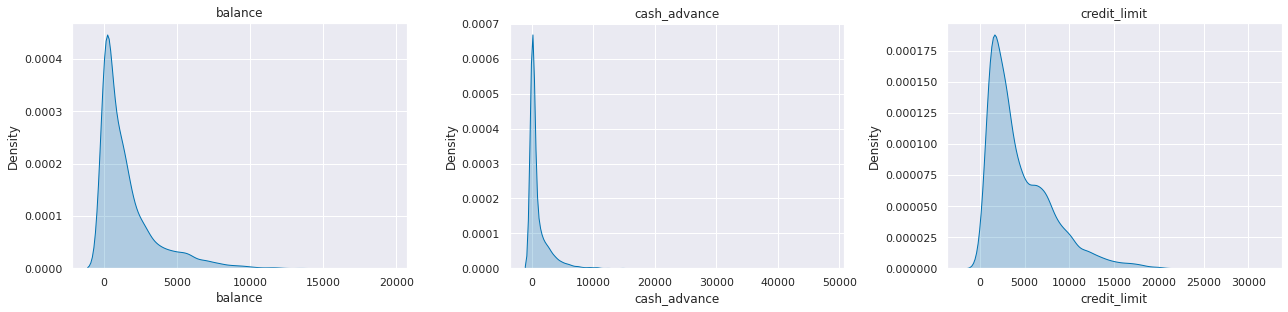

In [26]:
# plot distribution of each features
plt.figure(figsize=(18, 8))

for i, col in enumerate(['balance',  'cash_advance', 'credit_limit']):
    plt.subplot(2, 3, i+1)
    sns.kdeplot(X[col], shade=True, color='#0072B2')
    plt.title(col)

plt.tight_layout()
plt.show()

We can see that `balance`, `cash_advance`, and `credit_limit` are skewed distributions. They also seem to have a lot of outliers.

## Distribution of Data for Frequency Features

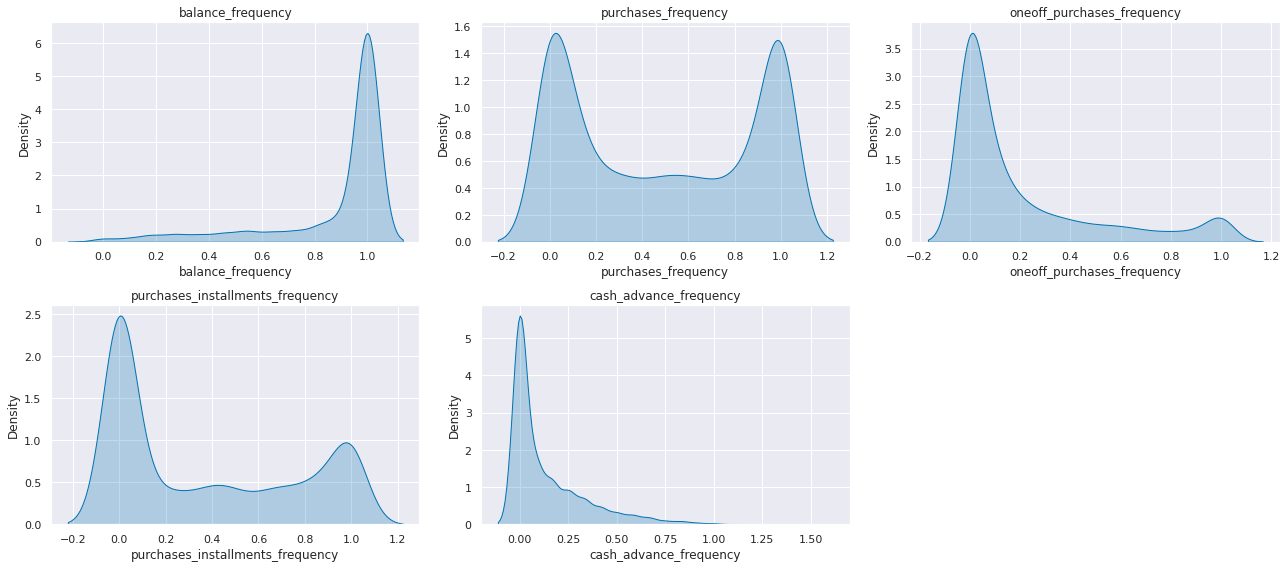

In [27]:
# plot distribution of each features
plt.figure(figsize=(18, 8))

for i, col in enumerate([col for col in X.columns.to_list() if 'frequency' in col]):
    plt.subplot(2, 3, i+1)
    sns.kdeplot(X[col], shade=True, color='#0072B2')
    plt.title(col)

plt.tight_layout()
plt.show()

We can see that the balance is frequently updated, hence why the profile is distributed around the value 1\
As for the `one_off_purchases_frequency`, `purchases_installments_frequency`, `cash_advance_frequency`, most of them are nearing the value 0, which means most credit card holder rarely use their credit card.\
However, observing the `purchases_frequency` feature, the distribution is actually separated between the left side and the right side, which means most customers are either use it frequently, or rarely use it.\
Amongst those who frequently use it, most common usage is, in order of frequency, for installments purchases, then oneoff purchases, then cash advances

## Distribution of Data for Purchases Features

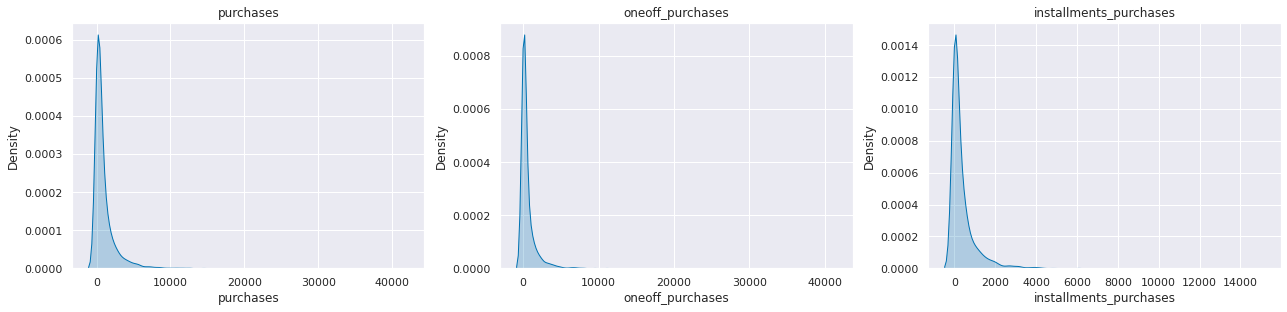

In [28]:
# plot distribution of each features
plt.figure(figsize=(18, 8))

for i, col in enumerate([col for col in X.columns.to_list() if 'purchases' in col and 'frequency' not in col and 'trx' not in col]):
    plt.subplot(2, 3, i+1)
    sns.kdeplot(X[col], shade=True, color='#0072B2')
    plt.title(col)

plt.tight_layout()
plt.show()

Seeing as all three features are centered near `0` and heavily right skewed, it seems like most people only purchase in small amounts

## Distribution of Data for Payments Features

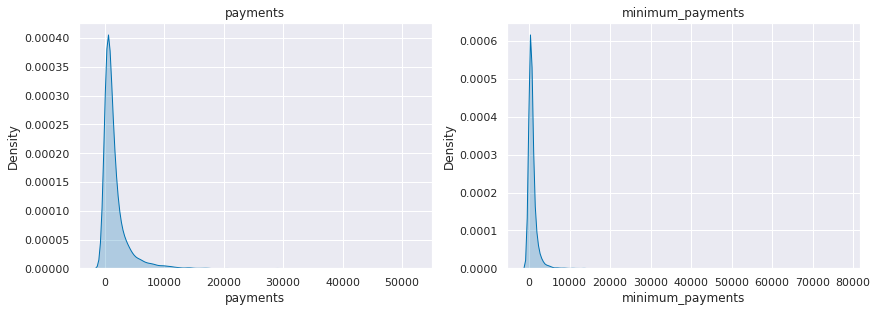

In [29]:
# plot distribution of each features
plt.figure(figsize=(18, 8))

for i, col in enumerate([col for col in X.columns.to_list() if 'payments' in col]):
    plt.subplot(2, 3, i+1)
    sns.kdeplot(X[col], shade=True, color='#0072B2')
    plt.title(col)

plt.tight_layout()
plt.show()

Both payments centered near `0`, which means most customers make payments in small amounts

## Distribution of Data for Transaction Features

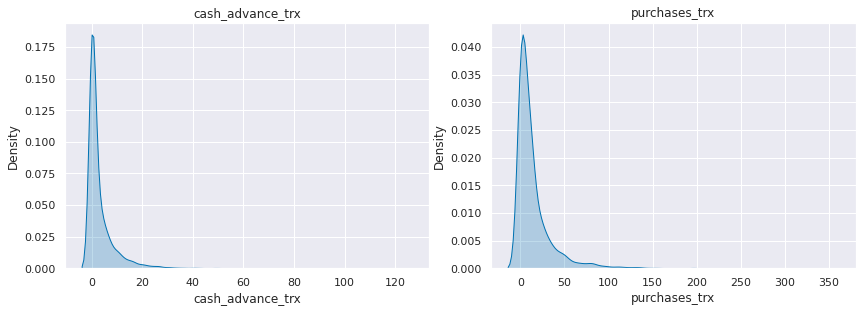

In [30]:
# plot distribution of each features
plt.figure(figsize=(18, 8))

for i, col in enumerate([col for col in X.columns.to_list() if 'trx' in col]):
    plt.subplot(2, 3, i+1)
    sns.kdeplot(X[col], shade=True, color='#0072B2')
    plt.title(col)

plt.tight_layout()
plt.show()

Since both number of transactions are near `0`, most customers rarely use their customer, while the outliers, the few, use them frequently, as seen from the number of transactions.\
We could also compare that people use their credit card more for purchases rather than cash advance, as seen by the larger value of the outliers and how the right side of the profile slope more modestly

## Distribution of Data Tenure

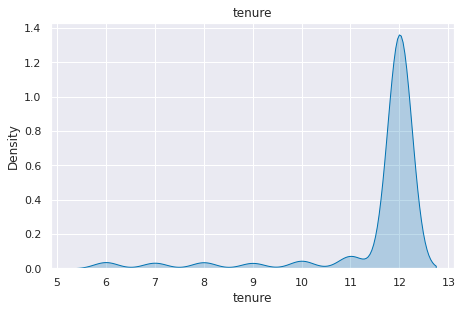

In [31]:
# plot distribution of each features
plt.figure(figsize=(18, 8))

for i, col in enumerate(['tenure']):
    plt.subplot(2, 3, i+1)
    sns.kdeplot(X[col], shade=True, color='#0072B2')
    plt.title(col)

plt.tight_layout()
plt.show()

Most of the tenure is centered around 12 months. This makes sense as most people might want to opt for the longest options for their installment

## Purchases Amount

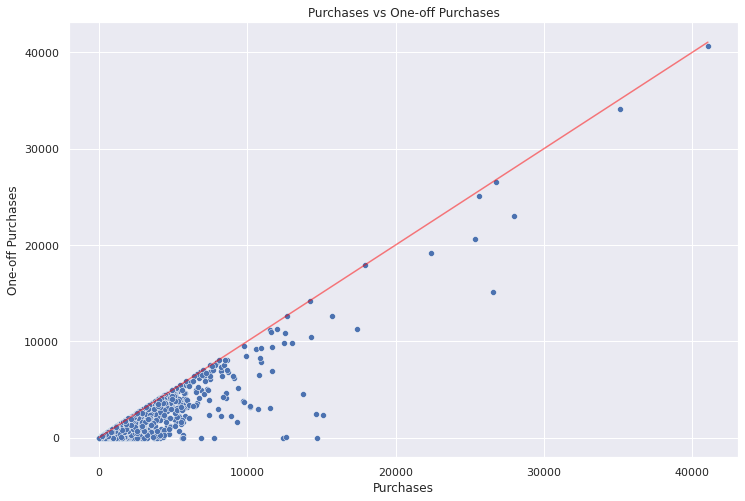

In [32]:
# plot correlation between purchases and oneoff purchases
plt.figure(figsize=(12,8))
# plot y=x
plt.plot([0, X['purchases'].max()], [0, X['purchases'].max()], color='red', alpha=0.5)
sns.scatterplot(data=X, x='purchases', y='oneoff_purchases')
plt.title('Purchases vs One-off Purchases')
plt.xlabel('Purchases')
plt.ylabel('One-off Purchases')
plt.show()

It seems like the amount of one off purchases cannot be higher than the value of purchases, because a one off purchase also counts as a purchase

In [33]:
# check if there's any one-off purchases higher than purchases
X[X['oneoff_purchases'] > X['purchases']]

balance  balance_frequency  purchases  oneoff_purchases  \
4219  3093.59                1.0      47.69             82.41   

      installments_purchases  cash_advance  purchases_frequency  \
4219                     0.0       1438.95                 0.17   

      oneoff_purchases_frequency  purchases_installments_frequency  \
4219                        0.08                               0.0   

      cash_advance_frequency  cash_advance_trx  purchases_trx  credit_limit  \
4219                    0.58                15              1        4100.0   

      payments  minimum_payments  prc_full_payment  tenure  
4219   4591.24            723.34               0.0      12

Surprisingly, there is one. And the value of one-off is double that of the purchase.

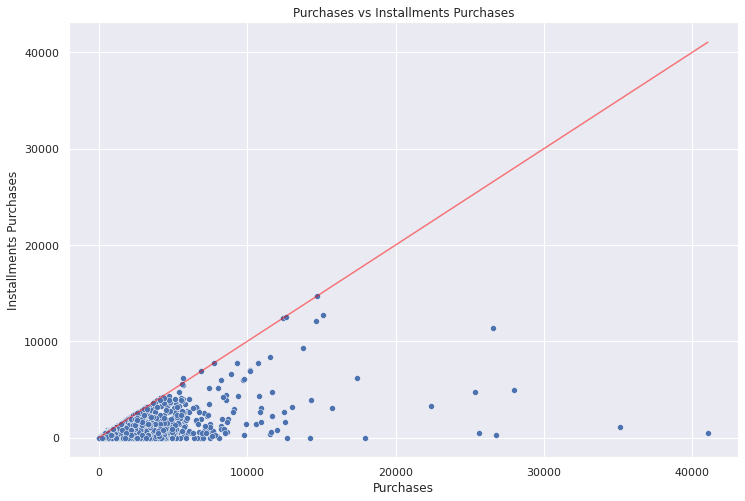

In [34]:
# plot correlation between purchases and installments
plt.figure(figsize=(12,8))
# plot y=x
plt.plot([0, X['purchases'].max()], [0, X['purchases'].max()], color='red', alpha=0.5)
sns.scatterplot(data=X, x='purchases', y='installments_purchases')
plt.title('Purchases vs Installments Purchases')
plt.xlabel('Purchases')
plt.ylabel('Installments Purchases')
plt.show()

This should be similar like one-off and purchases where the installments shouldn't be higher than the purchases variable. However, we can clearly see that there are some data where the installments are higher than the purchases. Is this caused by interest?

In [35]:
# check if there's any installments purchases higher than purchases
X[X['installments_purchases'] > X['purchases']]

balance  balance_frequency  purchases  oneoff_purchases  \
539     92.86               1.00     468.96               0.0   
1345     4.38               0.27     130.24               0.0   
1353   191.38               1.00     510.00               0.0   
1650   592.47               1.00    5629.41               0.0   
1916  1613.50               1.00      65.60               0.0   
3018  1089.80               1.00       0.00               0.0   

      installments_purchases  cash_advance  purchases_frequency  \
539                   498.96          0.00                 1.00   
1345                  152.24          0.00                 0.08   
1353                  780.00          0.00                 0.56   
1650                 6229.41          0.00                 0.92   
1916                  112.60          0.00                 0.40   
3018                   20.00         38.25                 0.00   

      oneoff_purchases_frequency  purchases_installments_frequency  \
539                          0.0                              0.83   
1345                         0.0                              0.08   
1353                         0.0                              0.44   
1650                         0.0                              1.00   
1916                         0.0                              0.30   
3018                         0.0                              0.17   

      cash_advance_frequency  cash_advance_trx  purchases_trx  credit_limit  \
539                     0.00                 0              5        1000.0   
1345                    0.00                 0              0       14000.0   
1353                    0.00                 0              7        1000.0   
1650                    0.00                 0             82        6000.0   
1916                    0.00                 0              5        5000.0   
3018                    0.08                 1              1        1200.0   

      payments  minimum_payments  prc_full_payment  tenure  
539     348.78             87.17              1.00       6  
1345  28988.97           1092.18              0.50      12  
1353    459.17            128.23              0.00       9  
1650   5723.33            187.96              0.83      12  
1916    390.92            426.14              0.00      10  
3018    284.73            331.10              0.00      12

Yup! We have 6 entries which met the criteria

By definition, `purchases` is supposed to be `oneoff_purchases` + `installments_purchases`. However, we can see there are a some data which violates this relationship

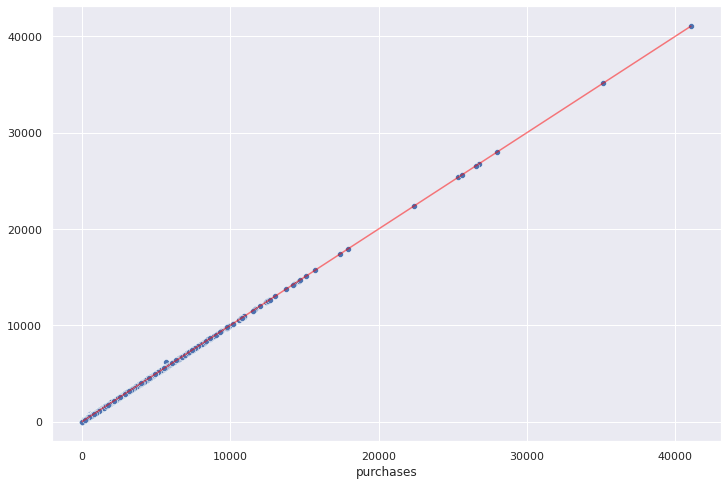

In [36]:
# plot correlation between purchases and cash_advance
plt.figure(figsize=(12,8))
# plot y=x
plt.plot([0, X['purchases'].max()], [0, X['purchases'].max()], color='red', alpha=0.5)
sns.scatterplot(data=X, x='purchases', y=X['oneoff_purchases']+X['installments_purchases'])
plt.show()

We can see there are some data points that are outside the straight line.

In [37]:
# check if there's any one-off purchases and installments purchases combined
# that is not the same as purchases
X[(X['oneoff_purchases'] + X['installments_purchases']) != X['purchases']]

balance  balance_frequency  purchases  oneoff_purchases  \
28    1739.13                1.0     191.98             96.00   
109     28.32                0.5     225.02            111.70   
118     15.01                1.0     108.95             49.80   
154    743.25                0.6    1610.06           1211.90   
162   2021.51                1.0    1582.84           1554.89   
...       ...                ...        ...               ...   
4366  1032.40                1.0     924.34            538.06   
4369  4114.72                1.0    1841.62           1456.94   
4405  2936.44                1.0    2177.32           1919.37   
4425  1325.68                1.0    1084.87            687.57   
4427  6063.98                1.0    3987.01           3531.24   

      installments_purchases  cash_advance  purchases_frequency  \
28                     95.98          0.00                 0.25   
109                   113.32          0.00                 0.38   
118                    59.15          0.00                 0.50   
154                   398.16          0.00                 0.50   
162                    27.95          0.00                 0.50   
...                      ...           ...                  ...   
4366                  386.28       1030.46                 0.75   
4369                  384.68       4004.27                 1.00   
4405                  257.95       1935.42                 0.67   
4425                  397.30       3330.91                 0.83   
4427                  455.77       2791.26                 0.83   

      oneoff_purchases_frequency  purchases_installments_frequency  \
28                          0.08                              0.25   
109                         0.12                              0.12   
118                         0.08                              0.33   
154                         0.20                              0.40   
162                         0.42                              0.08   
...                          ...                               ...   
4366                        0.25                              0.67   
4369                        1.00                              0.25   
4405                        0.42                              0.42   
4425                        0.33                              0.83   
4427                        0.42                              0.75   

      cash_advance_frequency  cash_advance_trx  purchases_trx  credit_limit  \
28                      0.00                 0              4        2000.0   
109                     0.00                 0              3       10000.0   
118                     0.00                 0              6        1500.0   
154                     0.00                 0             10        3500.0   
162                     0.00                 0              8        2500.0   
...                      ...               ...            ...           ...   
4366                    0.42                 5             15        1200.0   
4369                    0.42                 8             21        7500.0   
4405                    0.42                23             16        5000.0   
4425                    0.42                 9             16        3000.0   
4427                    0.42                13             25        7500.0   

      payments  minimum_payments  prc_full_payment  tenure  
28      978.45            634.09              0.00      12  
109     315.25            118.31              1.00       8  
118     149.85            131.97              0.11      12  
154     274.72            347.76              0.00      10  
162     565.38            486.70              0.00      12  
...        ...               ...               ...     ...  
4366   2011.28            520.32              0.00      12  
4369   7780.32            950.50              0.00      12  
4405   1513.16           2151.05              0.00      12  
4425   4135.41      

And these are the entries. It's weird, but we can't answer this finding as of yet. We would need to further look into it using information from outside the dataset. Was there an error in entry? Is there any method of calculating the variables that we do not know yet? These are good questions to be explored

# 5. Data Preprocessing

In [38]:
# restore the train set from the backup
X = X_ori.copy()

## Categorizing Features

Categorize the features based on the variable type of the features and the data it represents
- Numeric (Interval): Features which have equally spaced interval between unique values
- Categorical (Nominal): Features which have no intrinsic ordering to the unique values
- Ordinal: Features which have clear ordering but do not have equally spaced intervals between unique values

In [39]:
# categorizing features
num_cols = X.columns.to_list()

## Handling Outliers

In [40]:
outlier_summary(X, distance=1.5)

feats   skew    dist  tot_outlier  \
0                            balance   2.33  skewed          358   
1                  balance_frequency  -2.02  skewed          748   
2                          purchases   7.07  skewed          425   
3                   oneoff_purchases   9.94  skewed          523   
4             installments_purchases   6.32  skewed          442   
5                       cash_advance   5.64  skewed          503   
6                purchases_frequency   0.06  normal            0   
7         oneoff_purchases_frequency   1.55  skewed          556   
8   purchases_installments_frequency   0.51  skewed            0   
9             cash_advance_frequency   1.84  skewed          171   
10                  cash_advance_trx   6.45  skewed          400   
11                     purchases_trx   4.75  skewed          400   
12                      credit_limit   1.50  skewed          120   
13                          payments   5.75  skewed          412   
14                  minimum_payments  14.66  skewed          440   
15                  prc_full_payment   1.98  skewed          795   
16                            tenure  -2.96  skewed          696   

    tot_outlier_pct  
0              8.02  
1             16.75  
2              9.52  
3             11.71  
4              9.90  
5             11.27  
6              0.00  
7             12.45  
8              0.00  
9              3.83  
10             8.96  
11             8.96  
12             2.69  
13             9.23  
14             9.85  
15            17.81  
16            15.59

1. `Trimming`: if outliers' percentage < 5%
2. `Capping`: if outliers' percentage 5% - 15%
3. `None`: if outliers' percentage > 15%

In [41]:
# check outlier details
check_outlier(X, distance=1.5)

feats  upper_bound  lower_bound  \
0                            balance      4935.22     -2761.80   
1                  balance_frequency         1.17         0.72   
2                          purchases      2691.16     -1551.44   
3                   oneoff_purchases      1440.00      -864.00   
4             installments_purchases      1139.42      -683.65   
5                       cash_advance      2854.44     -1712.66   
6                purchases_frequency         1.70        -0.72   
7         oneoff_purchases_frequency         0.62        -0.38   
8   purchases_installments_frequency         1.88        -1.12   
9             cash_advance_frequency         0.62        -0.38   
10                  cash_advance_trx        10.00        -6.00   
11                     purchases_trx        41.00       -23.00   
12                      credit_limit     13850.00     -5750.00   
13                          payments      4219.22     -1928.72   
14                  minimum_payments      1795.92      -807.66   
15                  prc_full_payment         0.31        -0.19   
16                            tenure        12.00        12.00   

    tot_right_tail  tot_left_tail  tot_right_tail_pct  tot_left_tail_pct  \
0              358              0                8.02               0.00   
1                0            748                0.00              16.75   
2              425              0                9.52               0.00   
3              523              0               11.71               0.00   
4              442              0                9.90               0.00   
5              503              0               11.27               0.00   
6                0              0                0.00               0.00   
7              556              0               12.45               0.00   
8                0              0                0.00               0.00   
9              171              0                3.83               0.00   
10             400              0                8.96               0.00   
11             400              0                8.96               0.00   
12             120              0                2.69               0.00   
13             412              0                9.23               0.00   
14             440              0                9.85               0.00   
15             795              0               17.81               0.00   
16               0            696                0.00              15.59   

    tot_outlier  tot_outlier_pct  
0           358             8.02  
1           748            16.75  
2           425             9.52  
3           523            11.71  
4           442             9.90  
5           503            11.27  
6             0             0.00  
7           556            12.45  
8             0             0.00  
9           171             3.83  
10          400             8.96  
11          400             8.96  
12          120             2.69  
13          412             9.23  
14          440             9.85  
15          795            17.81  
16          696            15.59

Observing the dataset, I've decided that I'm not going to handle the outlier since these are all monetary values and represent the condition of the customers\
Trimming or capping it would make the outpuut unrepresentative of the dataset

## Handling Missing Values

In [42]:
# check missing values in train set
check_missing(X)

feats  tot_missing  tot_missing_pct
0  minimum_payments          155             3.47

In [43]:
# display missing values in train set
X[X.isna().any(axis=1)]

balance  balance_frequency  purchases  oneoff_purchases  \
0        3.83               0.12      45.00             45.00   
1        0.00               0.00     176.03            176.03   
6        0.23               0.12      60.00             60.00   
21    1464.32               1.00    1174.39           1174.39   
25      16.89               0.36    1083.00           1083.00   
...       ...                ...        ...               ...   
4261    19.95               0.11       0.00              0.00   
4262     0.00               0.00       0.00              0.00   
4264     8.19               0.11       0.00              0.00   
4266    26.00               0.11       0.00              0.00   
4348  3625.22               1.00     313.27            313.27   

      installments_purchases  cash_advance  purchases_frequency  \
0                        0.0          0.00                 0.12   
1                        0.0          0.00                 0.12   
6                        0.0          0.00                 0.12   
21                       0.0          0.00                 0.25   
25                       0.0          0.00                 0.25   
...                      ...           ...                  ...   
4261                     0.0        326.73                 0.00   
4262                     0.0        253.89                 0.00   
4264                     0.0        793.85                 0.00   
4266                     0.0        466.39                 0.00   
4348                     0.0        668.47                 0.25   

      oneoff_purchases_frequency  purchases_installments_frequency  \
0                           0.12                               0.0   
1                           0.12                               0.0   
6                           0.12                               0.0   
21                          0.25                               0.0   
25                          0.25                               0.0   
...                          ...                               ...   
4261                        0.00                               0.0   
4262                        0.00                               0.0   
4264                        0.00                               0.0   
4266                        0.00                               0.0   
4348                        0.25                               0.0   

      cash_advance_frequency  cash_advance_trx  purchases_trx  credit_limit  \
0                       0.00                 0              1         500.0   
1                       0.00                 0              1        7000.0   
6                       0.00                 0              1        1500.0   
21                      0.00                 0              8        9000.0   
25                      0.00                 0              3        1200.0   
...                      ...               ...            ...           ...   
4261                    0.11                 5              0        2500.0   
4262                    0.11                 1              0         500.0   
4264                    0.11                 1              0        1350.0   
4266                    0.11                 1              0        4000.0   
4348                    0.42                 5              4        4000.0   

      payments  minimum_payments  prc_full_payment  tenure  
0         0.00               NaN               0.0       8  
1         0.00               NaN               0.0       8  
6       438.74               NaN               0.0       8  
21        0.00               NaN               0.0      12  
25     3905.43               NaN               0.0      12  
...        ...               ...               ...     ...  
4261      0.00               NaN               0.0       9  
4262   2437.93               NaN               0.0       9  
4264      0.00               NaN               0.0       9  
4266      0.00      

`minimum_payments` is the minimum amount payment made by the user and the `payments` is the amount of payment done by the user. It seems like some of the Nan values in `minimum_payments`, has `0` in the `payments`. Let's see if it works the other way around. If all `0` payments has NaN in `minimum_payments`

In [44]:
# check if all the 0 values in `payments` have missing values
print(f'Total entries of `payments` with 0 value: {X[X["payments"] == 0].shape[0]}')
if (len(X[X['payments'] == 0]) == len(X[X['payments'] == 0].isna().any(axis=1))):
    print('All the 0 values in `payments` have missing values')

Total entries of `payments` with 0 value: 114
All the 0 values in `payments` have missing values


It turns out that it's true. All 0 `payments` have Nan `minimum_payments` and there are 114 of them, which about 70% of all the missing values.\
Therefore I guess it's safe to impute all the Nan `minimum_payments` with values from the `payments` feature

In [45]:
# impute missing values in `minimum_payments` with `payments`
X['minimum_payments'] = X['minimum_payments'].fillna(X['payments'])

In [46]:
# check missing values in train set
check_missing(X)

Empty DataFrame
Columns: [feats, tot_missing, tot_missing_pct]
Index: []

Great! There are no more missing values

## Feature Selection

### Heatmap Correlation Matrix for Numerical Features

We look at the Spearman's correlation matrix to find out the relation between features and target

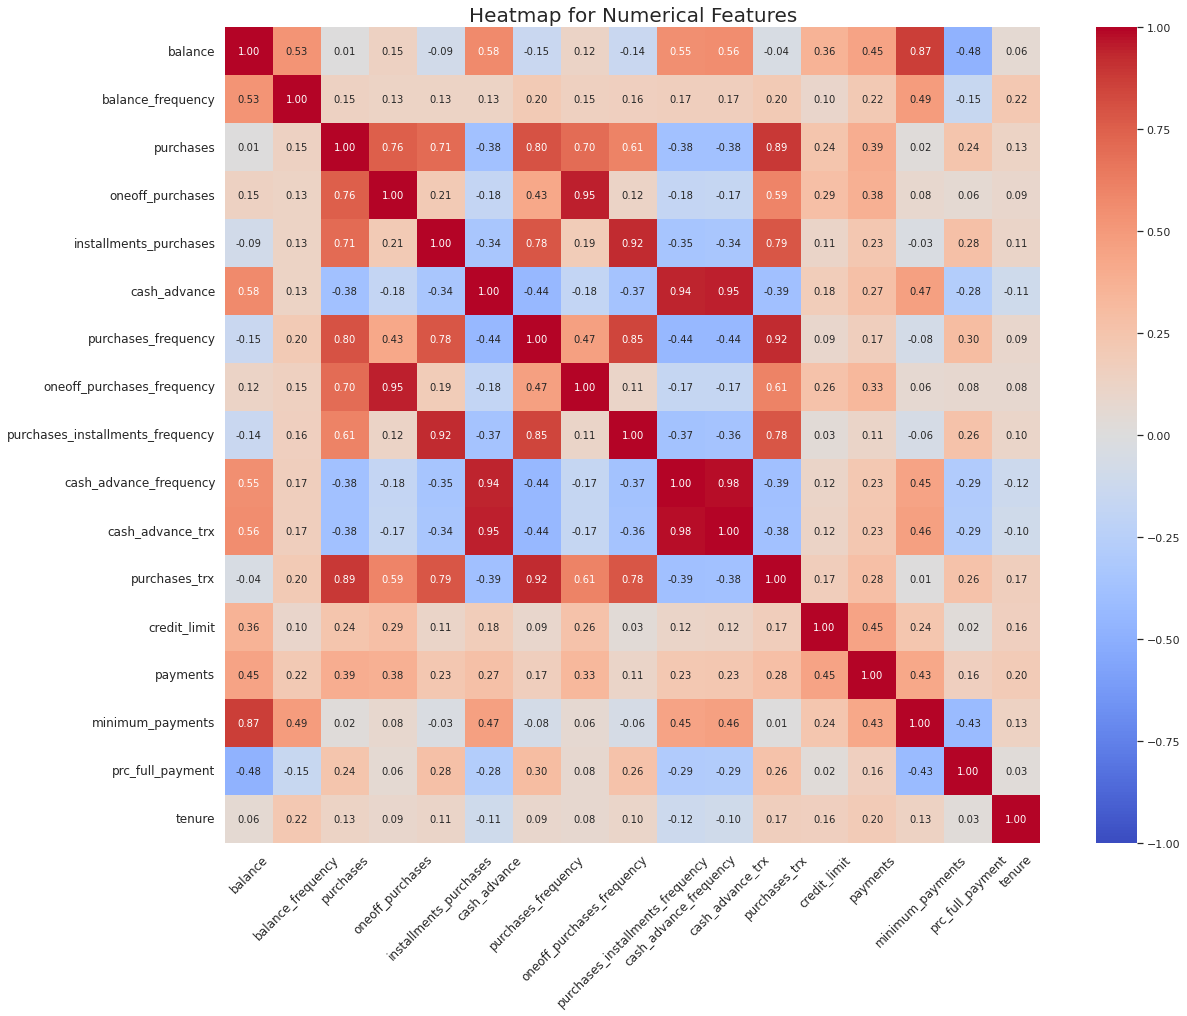

In [47]:
# Heatmap Correlation Matrix
plt.figure(figsize=(20,15))

sns.heatmap(
    X.corr('spearman'),
    annot=True, vmin=-1, vmax=1, fmt='.2f', square=True, cmap='coolwarm')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.title('Heatmap for Numerical Features', fontsize=20)

plt.show()

- However, since we do not really have any features that stand out, I'm going to use all features as predictors
- There are quite a number of features that are dependent on each other.
- For example, `purchases`, be it `oneoff` and `installment` have high correlations with each other
- `cash_advance_trx` aer also highly correlated with `cash_advance_trx`
- However, I'm not going to deliberately drop any features for now as I'm going to perform dimensionality reduction technique using PCA

### Categorizing Selected Features

In [48]:
outlier_summary(X, distance=1.5)

feats   skew    dist  tot_outlier  \
0                            balance   2.33  skewed          358   
1                  balance_frequency  -2.02  skewed          748   
2                          purchases   7.07  skewed          425   
3                   oneoff_purchases   9.94  skewed          523   
4             installments_purchases   6.32  skewed          442   
5                       cash_advance   5.64  skewed          503   
6                purchases_frequency   0.06  normal            0   
7         oneoff_purchases_frequency   1.55  skewed          556   
8   purchases_installments_frequency   0.51  skewed            0   
9             cash_advance_frequency   1.84  skewed          171   
10                  cash_advance_trx   6.45  skewed          400   
11                     purchases_trx   4.75  skewed          400   
12                      credit_limit   1.50  skewed          120   
13                          payments   5.75  skewed          412   
14                  minimum_payments  14.33  skewed          468   
15                  prc_full_payment   1.98  skewed          795   
16                            tenure  -2.96  skewed          696   

    tot_outlier_pct  
0              8.02  
1             16.75  
2              9.52  
3             11.71  
4              9.90  
5             11.27  
6              0.00  
7             12.45  
8              0.00  
9              3.83  
10             8.96  
11             8.96  
12             2.69  
13             9.23  
14            10.48  
15            17.81  
16            15.59

In [49]:
# create list of numerical features with normal distribution
num_cols_norm = ['purchases_frequency']

# create list of numerical features with skew
num_cols_skew = [
    'balance',
    'balance_frequency',
    'purchases',
    'oneoff_purchases',
    'installments_purchases',
    'cash_advance',
    'oneoff_purchases_frequency',
    'purchases_installments_frequency',
    'cash_advance_frequency',
    'cash_advance_trx',
    'purchases_trx',
    'credit_limit',
    'payments',
    'minimum_payments',
    'prc_full_payment',
    'tenure'
]

### List of Features

These are the predictors we're going to use

In [50]:
# print out list of predictors
print(f'Numerical Features ({len(num_cols_norm + num_cols_skew)}):')
print(num_cols_norm + num_cols_skew)

Numerical Features (17):
['purchases_frequency', 'balance', 'balance_frequency', 'purchases', 'oneoff_purchases', 'installments_purchases', 'cash_advance', 'oneoff_purchases_frequency', 'purchases_installments_frequency', 'cash_advance_frequency', 'cash_advance_trx', 'purchases_trx', 'credit_limit', 'payments', 'minimum_payments', 'prc_full_payment', 'tenure']


### Create Pipeline

Create a pipeline based on how we would engineer the features, whether to scale or to encode
- We will create multiple pipeline for scaling because each features and each models require different procedures in which we handle it
- All categorical features will use one hot encoder
- Ordinal features which 

In [51]:
# create pipeline for standardization
std_pipe = Pipeline([
    ('std_scaler', StandardScaler())
])

# create pipeline for min max scaling
min_max_pipe = Pipeline([
    ('min_max_scaler', MinMaxScaler())
])

# create pipeline for normalizer
power_pipe = Pipeline([
    ('power_transformer', PowerTransformer())
])

# create pipeline for robust scaler
robust_pipe = Pipeline([
    ('robust_scaler', RobustScaler())
])

# create pipeline for categorical features
nom_pipe = Pipeline([
    ('one_hot', OneHotEncoder(handle_unknown='ignore'))
])

### Create Column Transformer

Create a `ColumnTransformer` object based on the pipeline we have created

In [52]:
# create column transformer object using standard scaler
ct_std = ColumnTransformer([
    ('num_norm', std_pipe, num_cols_norm),
    ('num_skew', std_pipe, num_cols_skew),
])

# create column transformer object using min max scaler
ct_mm = ColumnTransformer([
    ('num_norm', std_pipe, num_cols_norm),
    ('num_skew', min_max_pipe, num_cols_skew),
])

# create column transformer object using power transform
ct_pt = ColumnTransformer([
    ('num_norm', std_pipe, num_cols_norm),
    ('num_skew', power_pipe, num_cols_skew),
])

# create column transformer object using robust scaler
ct_rs = ColumnTransformer([
    ('num_norm', std_pipe, num_cols_norm),
    ('num_skew', robust_pipe, num_cols_skew),
])

### Check for Multicollinearity

In [53]:
# create a DataFrame to store the variance inflation factor
vif_data = pd.DataFrame(X.columns, columns=['feats'])

vif_data['vif'] = [variance_inflation_factor(X, i) for i in range(len(X.columns))]

vif_data

feats       vif
0                            balance      4.15
1                  balance_frequency     17.86
2                          purchases  54318.16
3                   oneoff_purchases  31978.59
4             installments_purchases   9716.56
5                       cash_advance      3.55
6                purchases_frequency     26.54
7         oneoff_purchases_frequency      5.64
8   purchases_installments_frequency     17.18
9             cash_advance_frequency      4.79
10                  cash_advance_trx      3.74
11                     purchases_trx      4.27
12                      credit_limit      4.60
13                          payments      3.54
14                  minimum_payments      1.39
15                  prc_full_payment      1.71
16                            tenure     16.30

In [54]:
# check for moderately correlated features
print(f"There are {vif_data[vif_data['vif'] < 5].shape[0]} features with VIF < 5")
print(f"There are {vif_data[vif_data['vif'] >= 5].shape[0]} features with VIF >= 5")
vif_data[vif_data['vif'] < 5]

There are 9 features with VIF < 5
There are 8 features with VIF >= 5


feats   vif
0                  balance  4.15
5             cash_advance  3.55
9   cash_advance_frequency  4.79
10        cash_advance_trx  3.74
11           purchases_trx  4.27
12            credit_limit  4.60
13                payments  3.54
14        minimum_payments  1.39
15        prc_full_payment  1.71

Since we have 9 features which VIF scores are below 5, we can therefore probably reduce it to 10 features from 17

### Feature Scaling

In [55]:
# transform numerical features using column transformer
X_scaled = ct_mm.fit_transform(X)

# print X_scaled shape
print(f'X_scaled shape: {X_scaled.shape}')

X_scaled shape: (4465, 17)


## Dimensionality Reduction

### PCA

I want to see the graph of the explained variance, so I'm first going to declare PCA using the whole features

In [56]:
# declare PCA object using the whole features
pca = PCA(random_state=random_state)
pca.fit(X_scaled)

# calculate cumulative sum of the explained variance ratio
cumsum = np.cumsum(pca.explained_variance_ratio_)

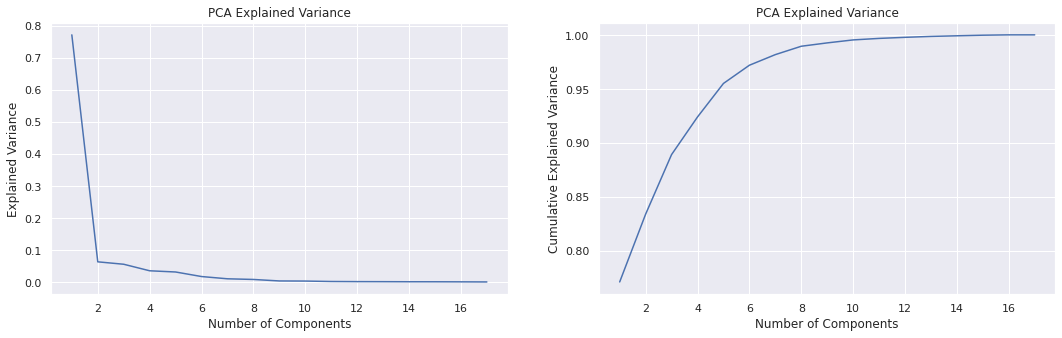

In [57]:
# plot the explained variance ratio
plt.figure(figsize=(18, 5))

# plot the explained variance ratio
plt.subplot(1, 2, 1)
plt.plot(range(1, X_scaled.shape[1]+1), pca.explained_variance_ratio_)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('PCA Explained Variance')

# plot the cumulative sum of the explained variance ratio
plt.subplot(1, 2, 2)
plt.plot(range(1, X_scaled.shape[1]+1), cumsum)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.show()

plt.show()

According to VIF, we can reduce our dimension to 10. However, looking at the EVR graph, using 2 components already resulted in a 80% cumulative EVR score, which is good enough

Let's now declare PCA with a preserve ratio of 0.8

In [58]:
# declare PCA object with the preserve ratio of 0.8
pca = PCA(n_components=0.8, random_state=random_state)

# perform dimensionality reduction
X_reduced = pca.fit_transform(X_scaled)

In [59]:
# display the number of components after dimensionality reduction
pca.n_components_

2

We can see that we have reduced the number of features from 17 to 5. The dataset is now about 10% of its original size. A very good compression\
The number of components is lower than that of the VIF method we got, but that's okay, since we've already got enough cumulative EVR score

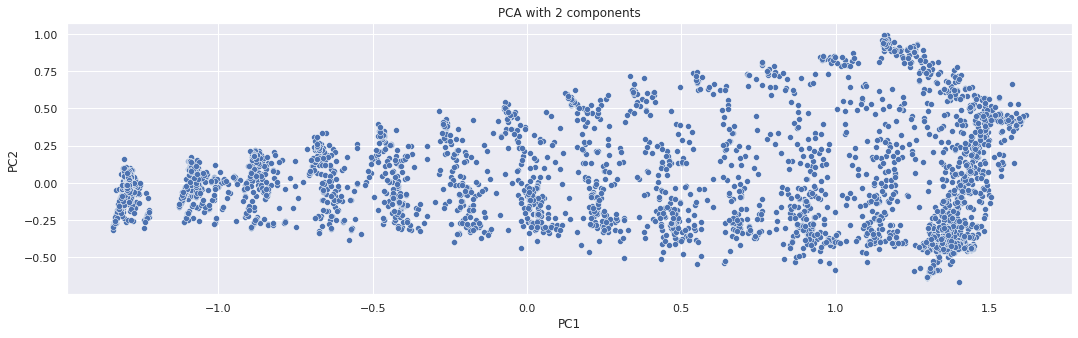

In [60]:
# plot pca with 2 components
pca_2d = PCA(n_components=2, random_state=random_state)
X_2d  = pca_2d.fit_transform(X_scaled)

plt.figure(figsize=(18, 5))
sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA with 2 components')
plt.show()

# 6. Model Definition

- Objective: Clustering


- Models: The Clustering Algorithms I'm going to test
    - K-Means
    - Agglomerative
    - Gaussian Mixtures

## K-Means

In [61]:
# declare kmeans object
kmeans = KMeans(n_clusters=5, random_state=random_state)

## Agglomerative

In [62]:
# declare agglomerative clustering object
agglo = AgglomerativeClustering(n_clusters=5)

## Gaussian Mixtures

In [63]:
# declare gaussian mixture object
gm = GaussianMixture(n_components=5, random_state=random_state)

# 7. Model Training

In [64]:
# create a dictionary of models
models = {
    'KMeans': kmeans,
    'Agglomerative': agglo,
    'Gaussian Mixture': gm
}

In [65]:
# fit all models using the reduced data set after dimensionality reduction
for name, model in models.items():
    model.fit(X_reduced)

# 8. Model Evaluation

## K-Means

In [66]:
# create a list for each kmeans cluster
kmeans_per_k = [KMeans(n_clusters=k, random_state=random_state).fit(X_reduced)
                for k in range(1, 15)]

### Inertia

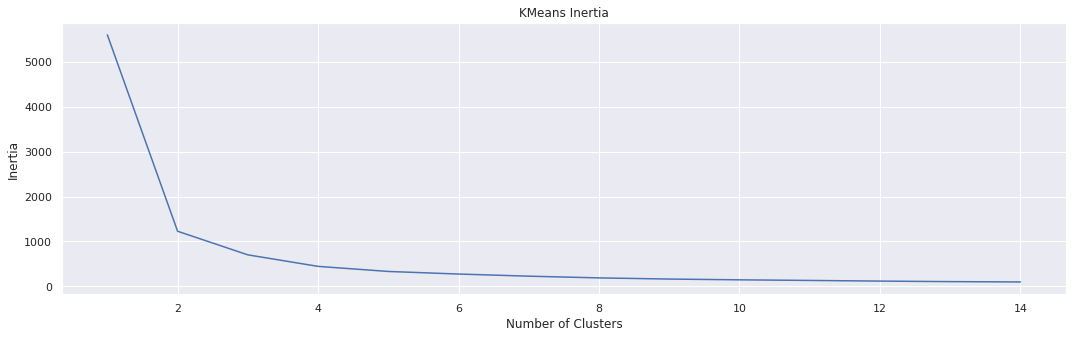

CPU times: user 548 ms, sys: 56.1 ms, total: 604 ms
Wall time: 487 ms


In [67]:
%%time

# plot inertia for each kmeans cluster
inertias = [model.inertia_ for model in kmeans_per_k]
plt.figure(figsize=(18, 5))
plt.plot(range(1, 15), inertias)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('KMeans Inertia')
plt.show()

It seems like the elbow is at 2 clusters, as seen by the sharp change in angle

### Silhouette Scores

In [68]:
%%time

# store silhouette scores for each kmeans cluster
silhouette_scores = [silhouette_score(X_reduced, model.labels_)
                     for model in kmeans_per_k[1:]]

CPU times: user 8.09 s, sys: 2.55 s, total: 10.6 s
Wall time: 6.07 s


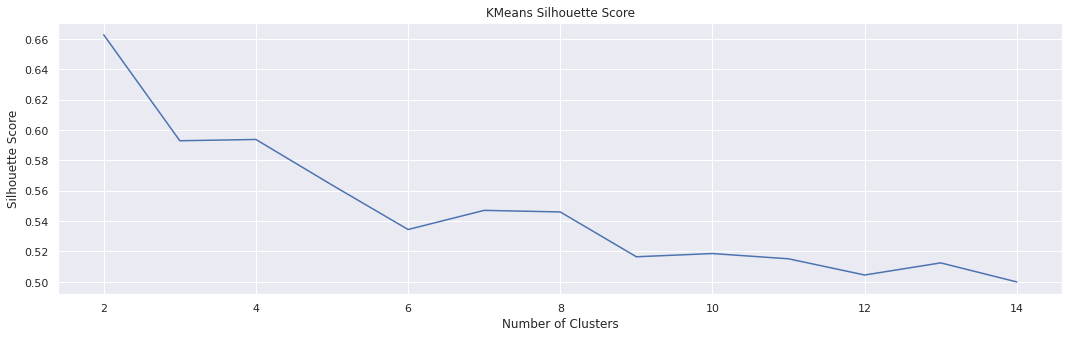

In [69]:
# plot silhouette scores for each kmeans cluster
plt.figure(figsize=(18, 5))
plt.plot(range(2, 15), silhouette_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('KMeans Silhouette Score')
plt.show()

Seems like using 2 clusters resulted in the best sihouette score

For n_clusters = 2 The average silhouette_score is : 0.6626958445767362
For n_clusters = 3 The average silhouette_score is : 0.5929368246940168
For n_clusters = 4 The average silhouette_score is : 0.5938060094260187
For n_clusters = 5 The average silhouette_score is : 0.5637951008647893
For n_clusters = 6 The average silhouette_score is : 0.5343846336934699
For n_clusters = 7 The average silhouette_score is : 0.5478891584451733
For n_clusters = 8 The average silhouette_score is : 0.5466199926908828
For n_clusters = 9 The average silhouette_score is : 0.5169176042393034
For n_clusters = 10 The average silhouette_score is : 0.5187051925159651
For n_clusters = 11 The average silhouette_score is : 0.5048234491065204
For n_clusters = 12 The average silhouette_score is : 0.5020033697228631
For n_clusters = 13 The average silhouette_score is : 0.5101592886031624
For n_clusters = 14 The average silhouette_score is : 0.5139436177553104


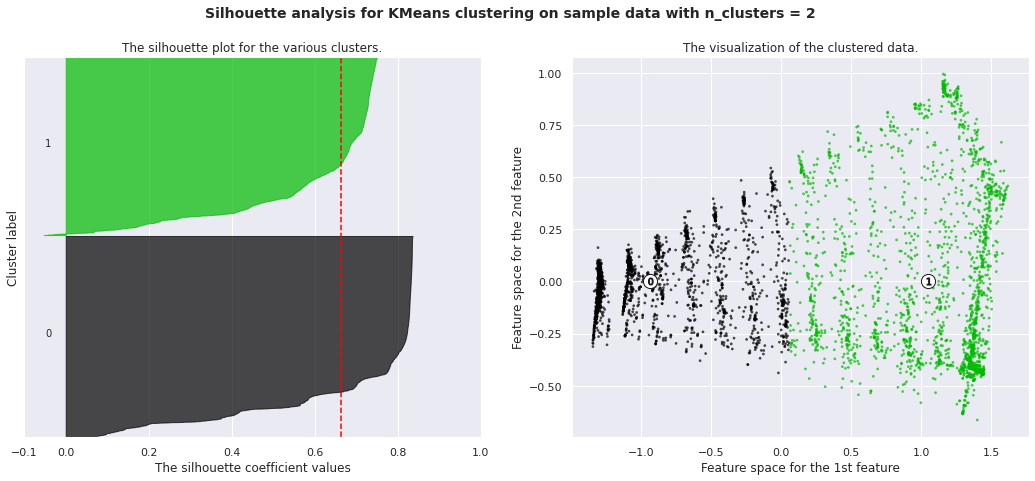

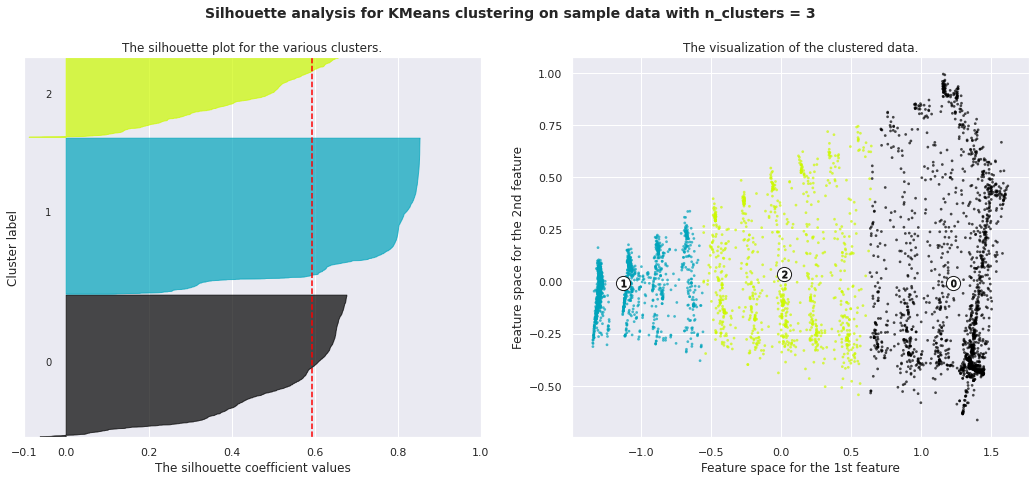

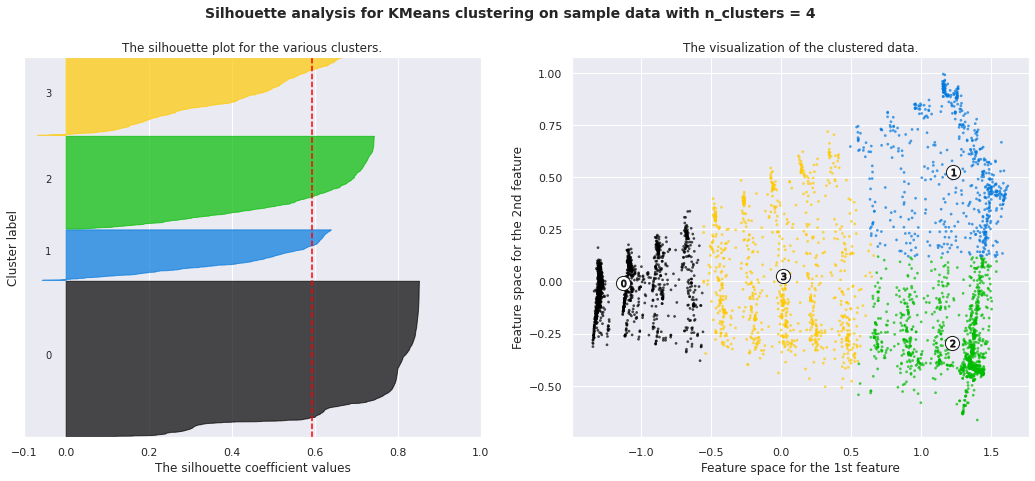

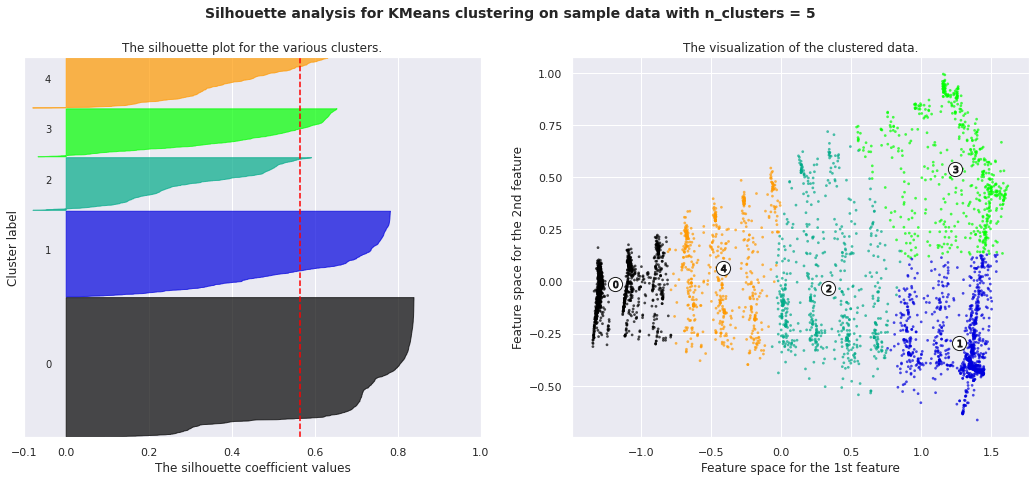

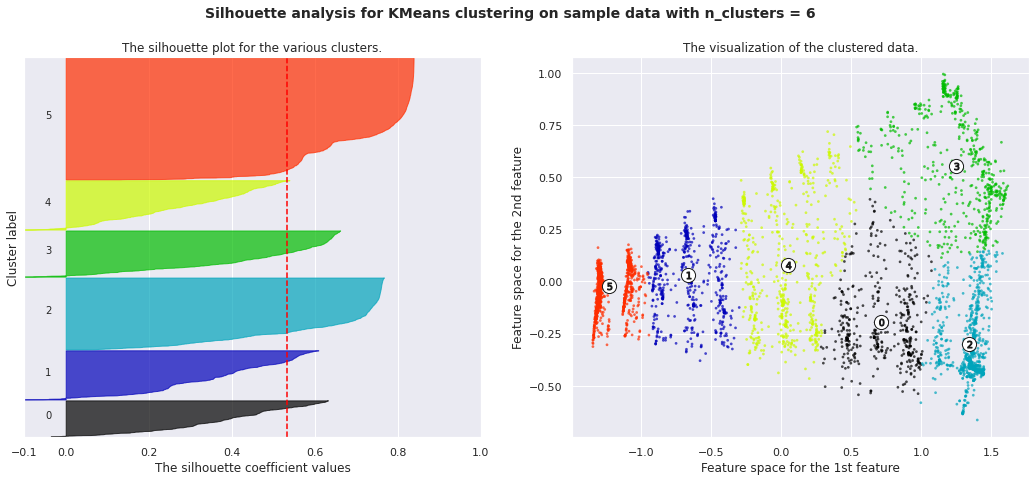

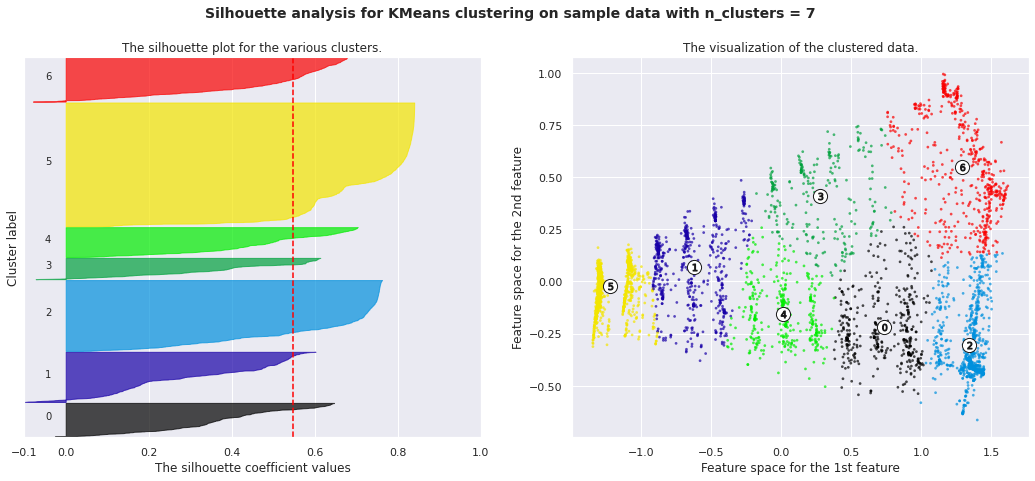

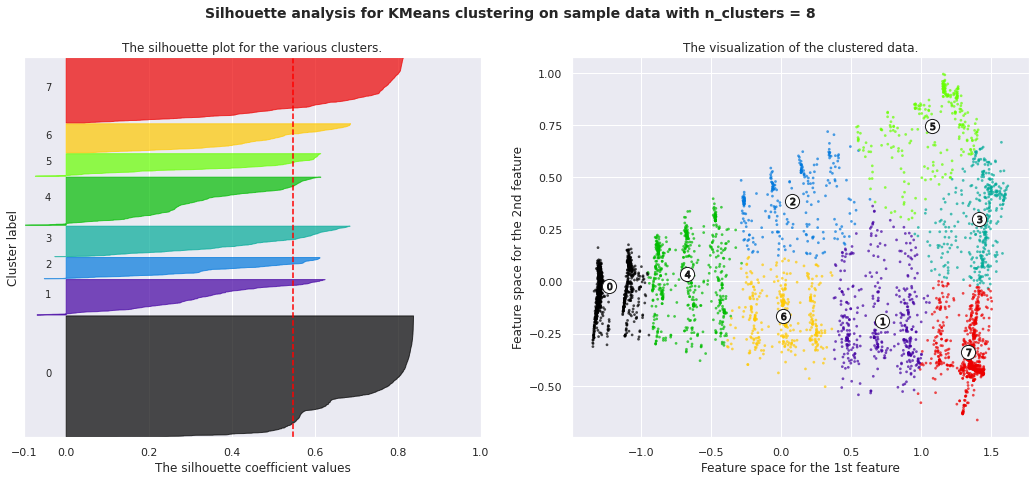

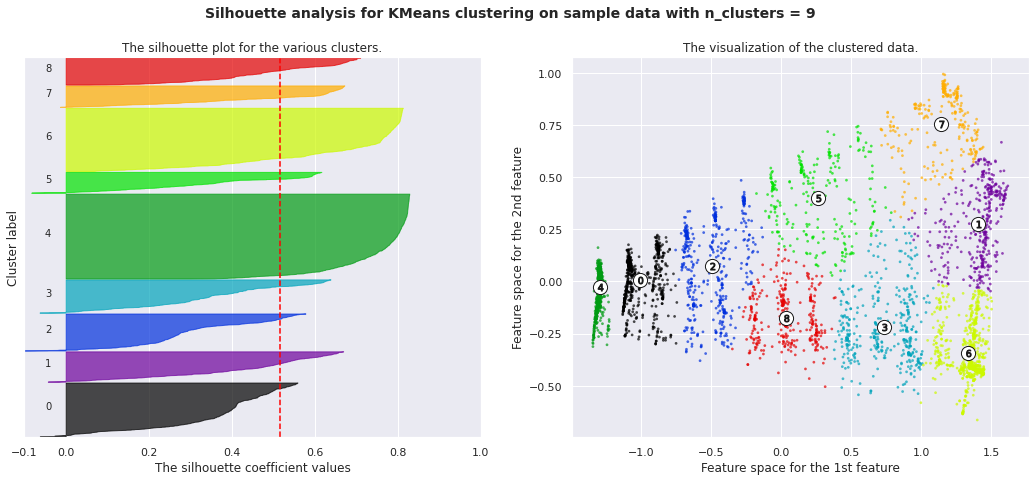

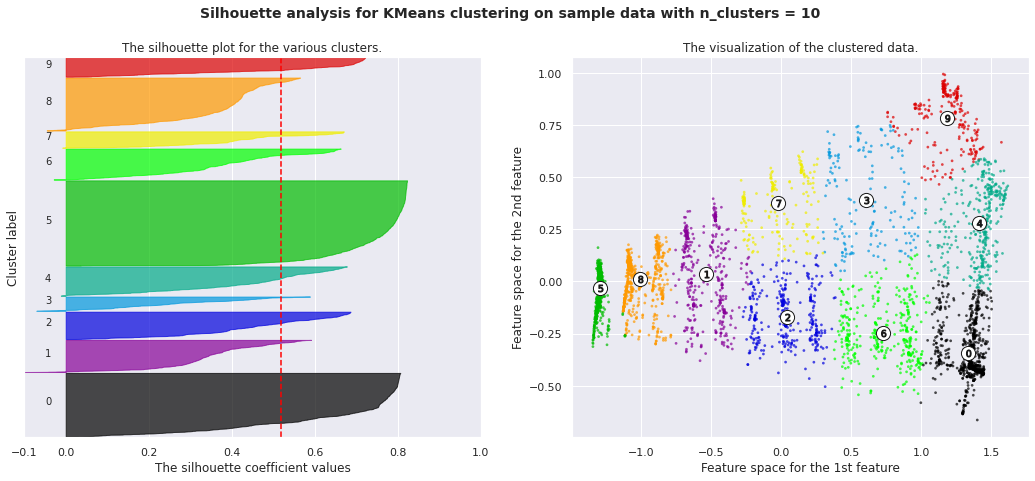

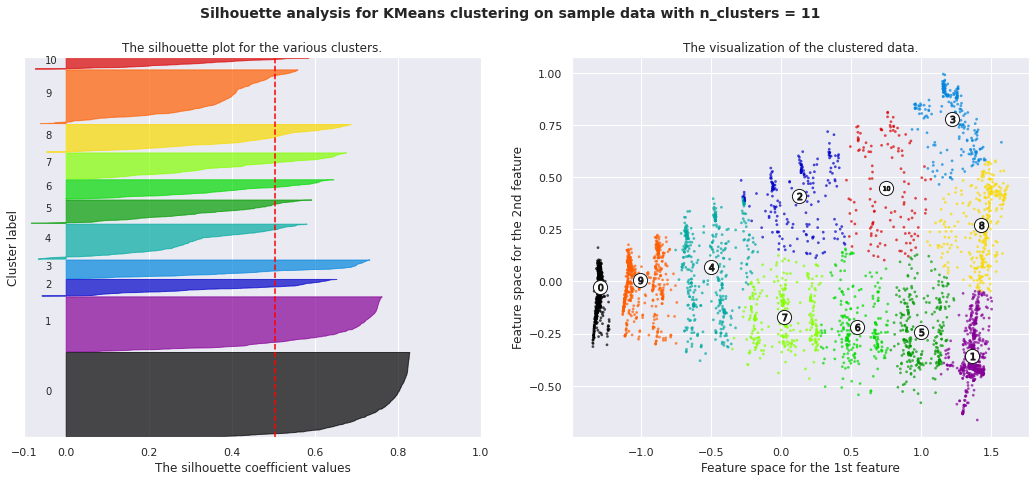

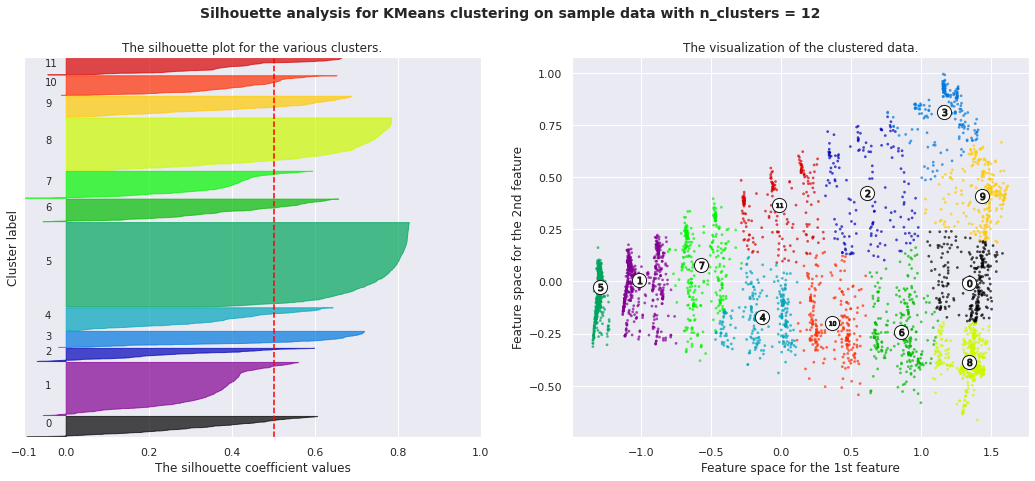

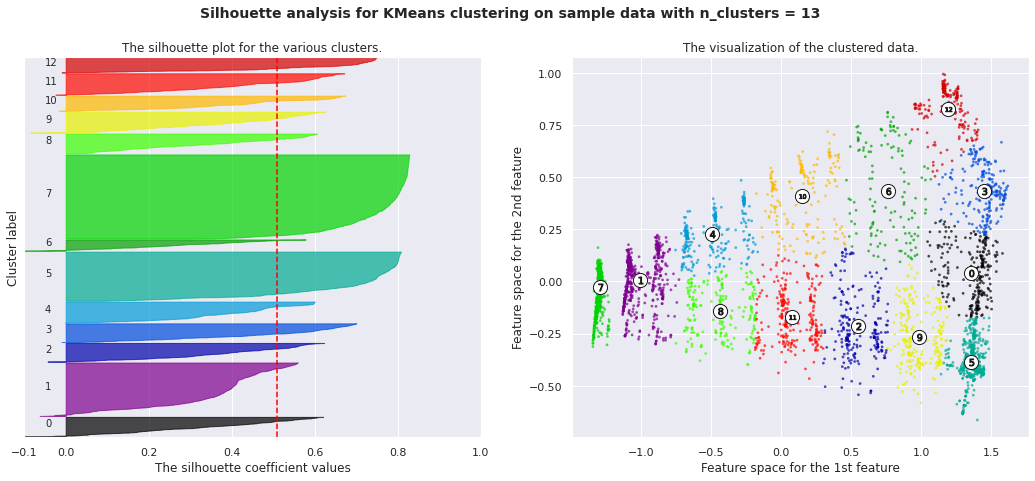

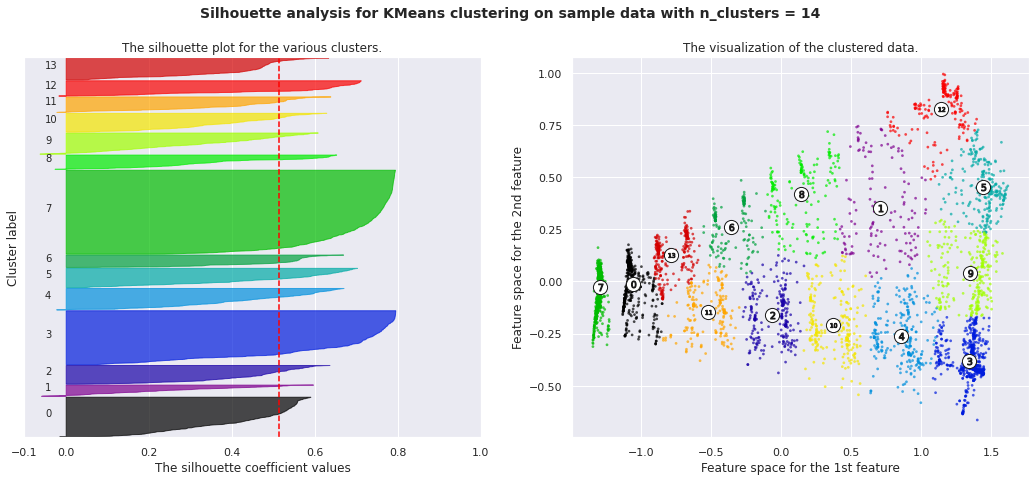

In [70]:
# plot silhouette diagram for each kmeans cluster
plot_silhouette(range_n_clusters=range(2, 15), X=X_reduced)

Observing the sihouette diagrams, we can see that using 2 clusters, we get good clusters, as all of the instances in a cluster have higher coefficient than the score.\
The diagram using 3 clusters is also pretty good as all instances have higher coefficient than the silhouette score. However, their clusters are not so similar to each other as cluster 2 is quite small compared to the other two.\
Therefore, I'm going to use `n_clusters = 2`, the same value we got from the inertias and highest silhouette score.

### Using the best number of clusters

In [71]:
# declare kmeans object with the best number of clusters
kmeans = KMeans(n_clusters=2, random_state=random_state)

# fit the kmeans model
kmeans.fit(X_reduced)

KMeans(n_clusters=2, random_state=42)

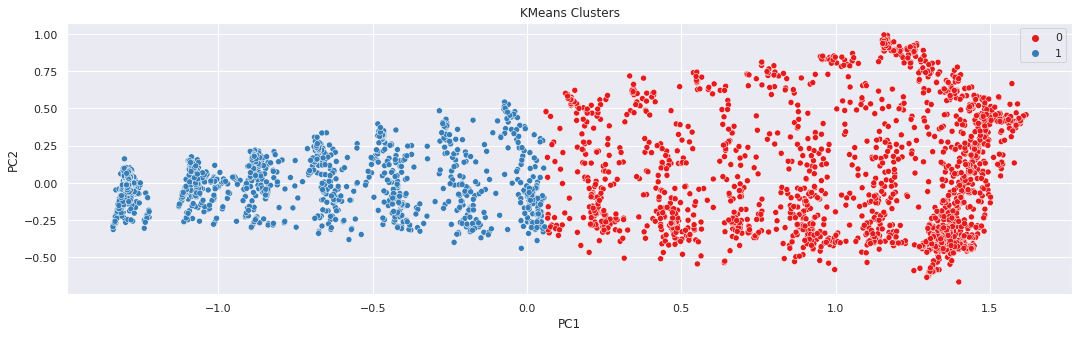

In [72]:
# plotting kmeans clusters in 2D
plt.figure(figsize=(18, 5))
sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=kmeans.labels_, palette='Set1')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('KMeans Clusters')
plt.show()

In [73]:
# copy from the train set to store kmeans labels
X_kmeans = X.copy()

# add cluster labels to the dataframe
X_kmeans['cluster'] = kmeans.labels_

# display the clustered dataframe
X_kmeans.head()

balance  balance_frequency  purchases  oneoff_purchases  \
0     3.83               0.12      45.00             45.00   
1     0.00               0.00     176.03            176.03   
2   757.96               0.88     157.40            157.40   
3   264.57               0.38    1150.00           1150.00   
4   440.61               1.00     600.00            600.00   

   installments_purchases  cash_advance  purchases_frequency  \
0                     0.0           0.0                 0.12   
1                     0.0           0.0                 0.12   
2                     0.0           0.0                 0.12   
3                     0.0           0.0                 0.12   
4                     0.0           0.0                 0.12   

   oneoff_purchases_frequency  purchases_installments_frequency  \
0                        0.12                               0.0   
1                        0.12                               0.0   
2                        0.12                               0.0   
3                        0.12                               0.0   
4                        0.12                               0.0   

   cash_advance_frequency  cash_advance_trx  purchases_trx  credit_limit  \
0                     0.0                 0              1         500.0   
1                     0.0                 0              1        7000.0   
2                     0.0                 0              6        1200.0   
3                     0.0                 0              1        1200.0   
4                     0.0                 0              1        1000.0   

   payments  minimum_payments  prc_full_payment  tenure  cluster  
0      0.00              0.00               0.0       8        1  
1      0.00              0.00               0.0       8        1  
2   1494.48           2638.60               0.0       8        1  
3   3029.38             85.43               0.0       8        1  
4    215.32            137.85               0.0       8        1

### EDA on Clustered Set

In [74]:
# value counts for each cluster
X_kmeans['cluster'].value_counts()

1    2369
0    2096
Name: cluster, dtype: int64

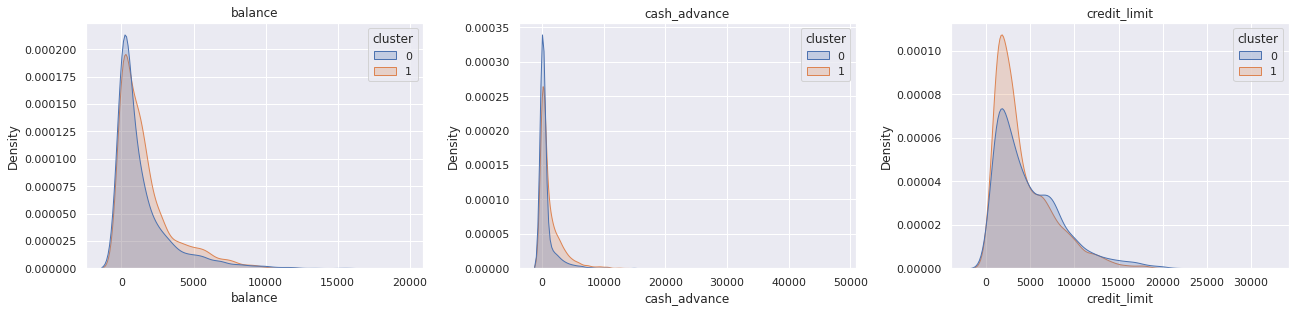

In [75]:
# plot distribution of each features
plt.figure(figsize=(18, 8))

for i, col in enumerate(['balance',  'cash_advance', 'credit_limit']):
    plt.subplot(2, 3, i+1)
    sns.kdeplot(X_kmeans[col], shade=True, color='#0072B2', hue=X_kmeans['cluster'])
    plt.title(col)

plt.tight_layout()
plt.show()

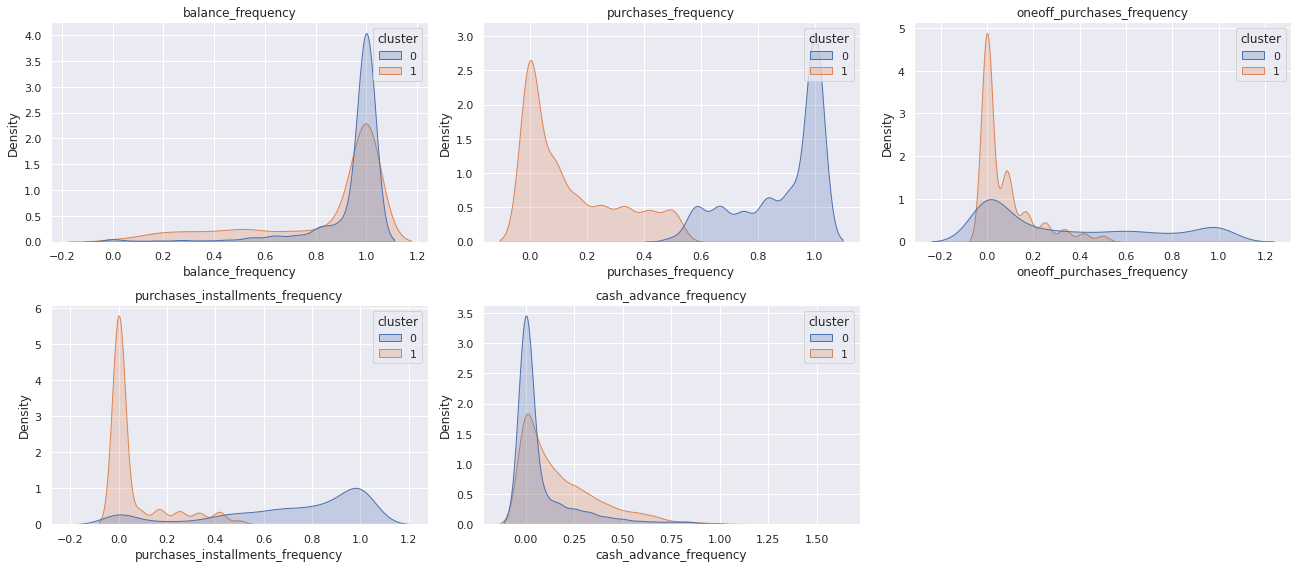

In [76]:
# plot distribution of each features
plt.figure(figsize=(18, 8))

for i, col in enumerate([col for col in X_kmeans.columns.to_list() if 'frequency' in col]):
    plt.subplot(2, 3, i+1)
    sns.kdeplot(X_kmeans[col], shade=True, color='#0072B2', hue=X_kmeans['cluster'])
    plt.title(col)

plt.tight_layout()
plt.show()

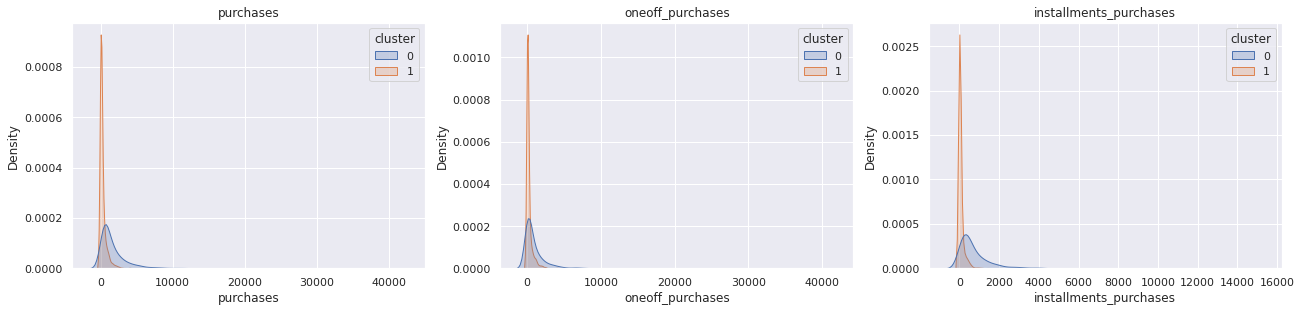

In [77]:
# plot distribution of each features
plt.figure(figsize=(18, 8))

for i, col in enumerate([col for col in X_kmeans.columns.to_list() if 'purchases' in col and 'frequency' not in col and 'trx' not in col]):
    plt.subplot(2, 3, i+1)
    sns.kdeplot(X_kmeans[col], shade=True, color='#0072B2', hue=X_kmeans['cluster'])
    plt.title(col)

plt.tight_layout()
plt.show()

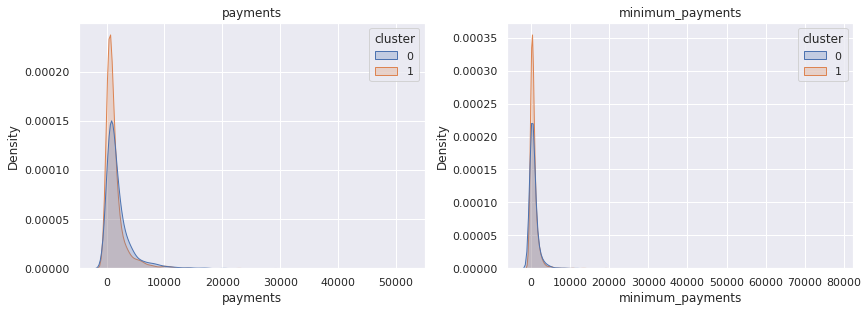

In [78]:
# plot distribution of each features
plt.figure(figsize=(18, 8))

for i, col in enumerate([col for col in X_kmeans.columns.to_list() if 'payments' in col]):
    plt.subplot(2, 3, i+1)
    sns.kdeplot(X_kmeans[col], shade=True, color='#0072B2', hue=X_kmeans['cluster'])
    plt.title(col)

plt.tight_layout()
plt.show()

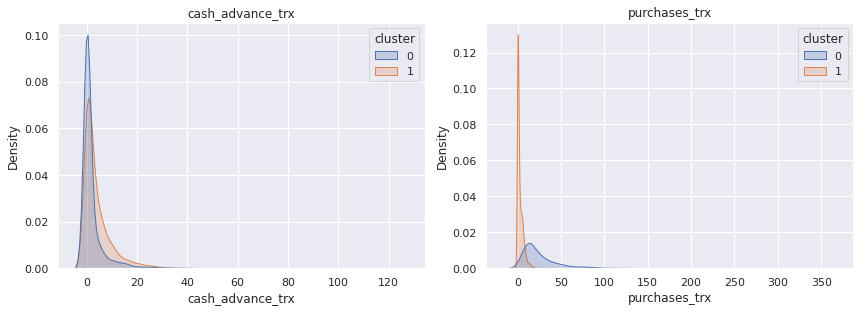

In [79]:
# plot distribution of each features
plt.figure(figsize=(18, 8))

for i, col in enumerate([col for col in X_kmeans.columns.to_list() if 'trx' in col]):
    plt.subplot(2, 3, i+1)
    sns.kdeplot(X_kmeans[col], shade=True, color='#0072B2', hue=X_kmeans['cluster'])
    plt.title(col)

plt.tight_layout()
plt.show()

In [80]:
# display the mean of each cluster
X_kmeans.groupby('cluster').mean()

balance  balance_frequency  purchases  oneoff_purchases  \
cluster                                                            
0        1441.36               0.94    1823.04           1028.01   
1        1672.28               0.82     279.31            215.48   

         installments_purchases  cash_advance  purchases_frequency  \
cluster                                                              
0                        795.46        638.50                 0.88   
1                         63.89       1291.08                 0.14   

         oneoff_purchases_frequency  purchases_installments_frequency  \
cluster                                                                 
0                              0.34                              0.70   
1                              0.08                              0.06   

         cash_advance_frequency  cash_advance_trx  purchases_trx  \
cluster                                                            
0                          0.09              2.23          28.87   
1                          0.18              4.24           2.59   

         credit_limit  payments  minimum_payments  prc_full_payment  tenure  
cluster                                                                      
0             4897.86   2096.51            918.18              0.25   11.57  
1             4146.00   1426.79            814.93              0.07   11.47

In [81]:
# display the median of each cluster
X_kmeans.groupby('cluster').median()

balance  balance_frequency  purchases  oneoff_purchases  \
cluster                                                            
0         589.41                1.0     975.73             300.0   
1        1060.01                1.0      55.65               0.0   

         installments_purchases  cash_advance  purchases_frequency  \
cluster                                                              
0                        455.75          0.00                 1.00   
1                          0.00        354.35                 0.08   

         oneoff_purchases_frequency  purchases_installments_frequency  \
cluster                                                                 
0                              0.17                              0.83   
1                              0.00                              0.00   

         cash_advance_frequency  cash_advance_trx  purchases_trx  \
cluster                                                            
0                          0.00               0.0           18.0   
1                          0.08               2.0            1.0   

         credit_limit  payments  minimum_payments  prc_full_payment  tenure  
cluster                                                                      
0              4000.0   1155.65            231.47               0.0    12.0  
1              3000.0    676.50            352.17               0.0    12.0

We have successfully divided the data set into 2 clusters. Observing the distribution plot, median, and mean of each clusters, we can come to a conclusion
- `Cluster 0`
    - Purchases more frequently
    - Uses purchases installments more frequently
    - Doesn't tend to use cash advance
    - Has higher purchases amount
- `Cluster 1`
    - Purchases less frequently
    - Uses purchases installments less frequently
    - Slightly uses cash advance more frequently
    - Has lower purchases amount

This is consistent with our EDA

### Create a pipeline

In [82]:
# create a pipeline for kmeans using the best number of clusters
kmeans_pipe = Pipeline([
    ('ct', ct_mm),
    ('pca', PCA(n_components=0.8, random_state=random_state)),
    ('kmeans', KMeans(n_clusters=2, random_state=random_state))
])

# fit the pipeline to the data
kmeans_pipe.fit(X)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num_norm',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['purchases_frequency']),
                                                 ('num_skew',
                                                  Pipeline(steps=[('min_max_scaler',
                                                                   MinMaxScaler())]),
                                                  ['balance',
                                                   'balance_frequency',
                                                   'purchases',
                                                   'oneoff_purchases',
                                                   'installments_purchases',
                                                   'cash_advance',
                                                   'oneoff_purchases_frequency',
                                                   'purchases_installments_frequency',
                                                   'cash_advance_frequency',
                                                   'cash_advance_trx',
                                                   'purchases_trx',
                                                   'credit_limit', 'payments',
                                                   'minimum_payments',
                                                   'prc_full_payment',
                                                   'tenure'])])),
                ('pca', PCA(n_components=0.8, random_state=42)),
                ('kmeans', KMeans(n_clusters=2, random_state=42))])

## Agglomerative Clustering

In [83]:
# create a list for each aglo clustering
agg_per_k = [AgglomerativeClustering(n_clusters=k).fit(X_reduced)
             for k in range(1, 15)]

### Silhouette Score

In [84]:
%%time

# store silhouette scores for each kmeans cluster
silhouette_scores = [silhouette_score(X_reduced, model.labels_)
                     for model in agg_per_k[1:]]

CPU times: user 7.65 s, sys: 2.55 s, total: 10.2 s
Wall time: 5.94 s


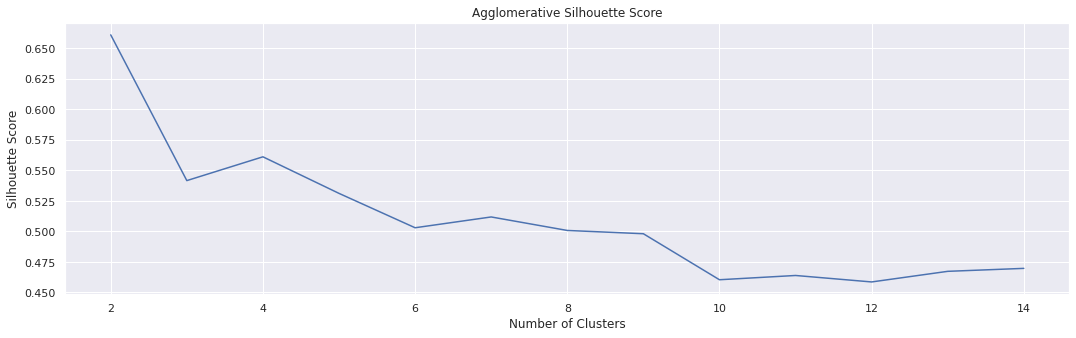

In [85]:
# plot silhouette scores for each kmeans cluster
plt.figure(figsize=(18, 5))
plt.plot(range(2, 15), silhouette_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Agglomerative Silhouette Score')
plt.show()

Seems like as it was in KMeans, the best silhouette score is also when using 2 as the number of clusters. I'm not going to plot the silhouette diagram for this method as going by the silhouette score is good enough

### Using the best number of clusters

In [86]:
# declare kmeans object with the best number of clusters
agglo = AgglomerativeClustering(n_clusters=2)

# fit the kmeans model
agglo.fit(X_reduced)

AgglomerativeClustering()

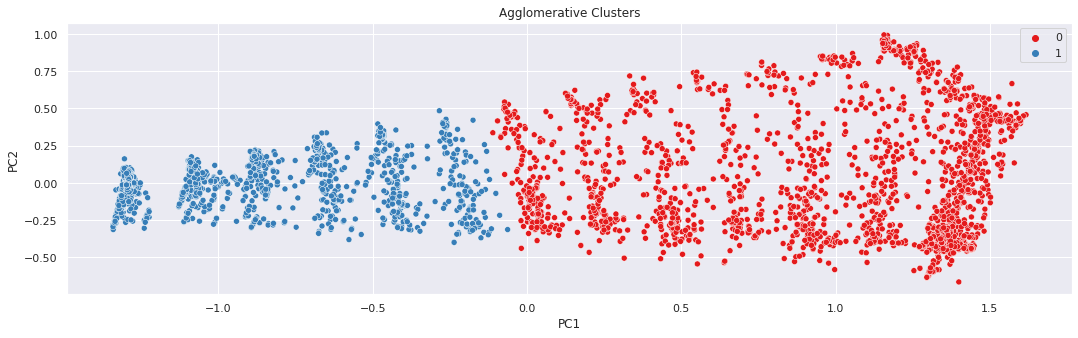

In [87]:
# plotting kmeans clusters in 2D
plt.figure(figsize=(18, 5))
sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=agglo.labels_, palette='Set1')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Agglomerative Clusters')
plt.show()

In [88]:
# copy from the train set to store agglomerative labels
X_agglo = X.copy()

# add cluster labels to the dataframe
X_agglo['cluster'] = agglo.labels_

# display the clustered dataframe
X_agglo.head()

balance  balance_frequency  purchases  oneoff_purchases  \
0     3.83               0.12      45.00             45.00   
1     0.00               0.00     176.03            176.03   
2   757.96               0.88     157.40            157.40   
3   264.57               0.38    1150.00           1150.00   
4   440.61               1.00     600.00            600.00   

   installments_purchases  cash_advance  purchases_frequency  \
0                     0.0           0.0                 0.12   
1                     0.0           0.0                 0.12   
2                     0.0           0.0                 0.12   
3                     0.0           0.0                 0.12   
4                     0.0           0.0                 0.12   

   oneoff_purchases_frequency  purchases_installments_frequency  \
0                        0.12                               0.0   
1                        0.12                               0.0   
2                        0.12                               0.0   
3                        0.12                               0.0   
4                        0.12                               0.0   

   cash_advance_frequency  cash_advance_trx  purchases_trx  credit_limit  \
0                     0.0                 0              1         500.0   
1                     0.0                 0              1        7000.0   
2                     0.0                 0              6        1200.0   
3                     0.0                 0              1        1200.0   
4                     0.0                 0              1        1000.0   

   payments  minimum_payments  prc_full_payment  tenure  cluster  
0      0.00              0.00               0.0       8        1  
1      0.00              0.00               0.0       8        1  
2   1494.48           2638.60               0.0       8        1  
3   3029.38             85.43               0.0       8        1  
4    215.32            137.85               0.0       8        1

### EDA on Clustered Set

In [89]:
# value counts for each cluster
X_agglo['cluster'].value_counts()

0    2265
1    2200
Name: cluster, dtype: int64

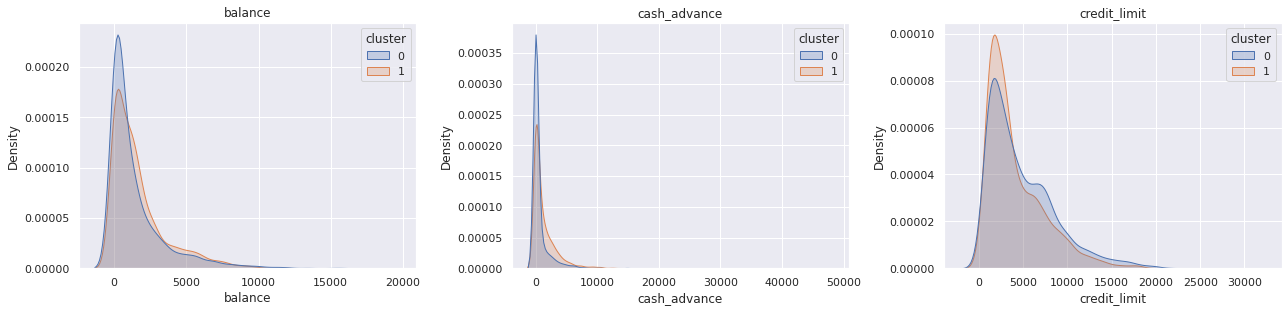

In [90]:
# plot distribution of each features
plt.figure(figsize=(18, 8))

for i, col in enumerate(['balance',  'cash_advance', 'credit_limit']):
    plt.subplot(2, 3, i+1)
    sns.kdeplot(X_agglo[col], shade=True, color='#0072B2', hue=X_agglo['cluster'])
    plt.title(col)

plt.tight_layout()
plt.show()

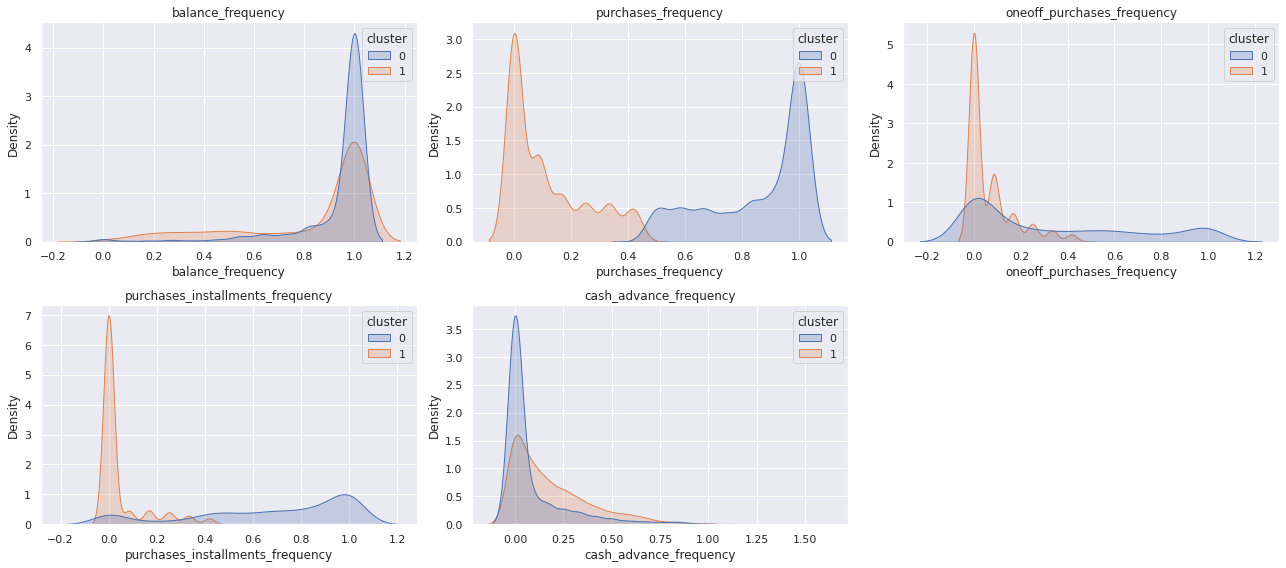

In [91]:
# plot distribution of each features
plt.figure(figsize=(18, 8))

for i, col in enumerate([col for col in X_agglo.columns.to_list() if 'frequency' in col]):
    plt.subplot(2, 3, i+1)
    sns.kdeplot(X_agglo[col], shade=True, color='#0072B2', hue=X_agglo['cluster'])
    plt.title(col)

plt.tight_layout()
plt.show()

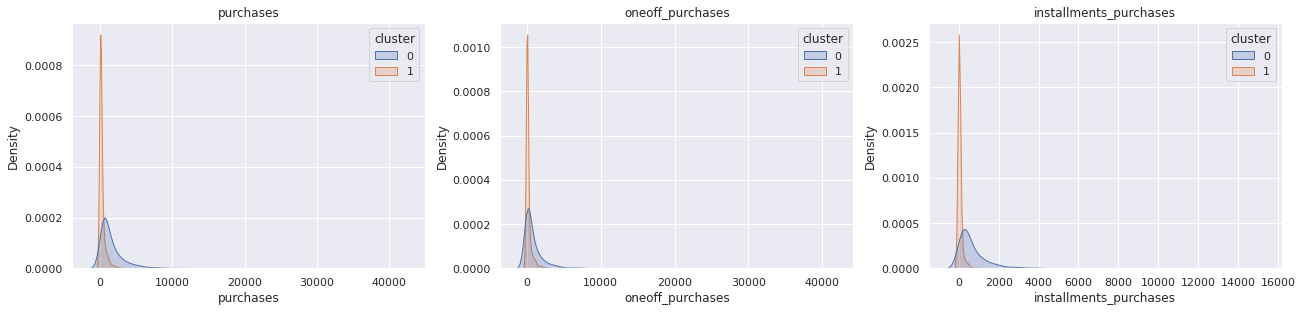

In [92]:
# plot distribution of each features
plt.figure(figsize=(18, 8))

for i, col in enumerate([col for col in X_agglo.columns.to_list() if 'purchases' in col and 'frequency' not in col and 'trx' not in col]):
    plt.subplot(2, 3, i+1)
    sns.kdeplot(X_agglo[col], shade=True, color='#0072B2', hue=X_agglo['cluster'])
    plt.title(col)

plt.tight_layout()
plt.show()

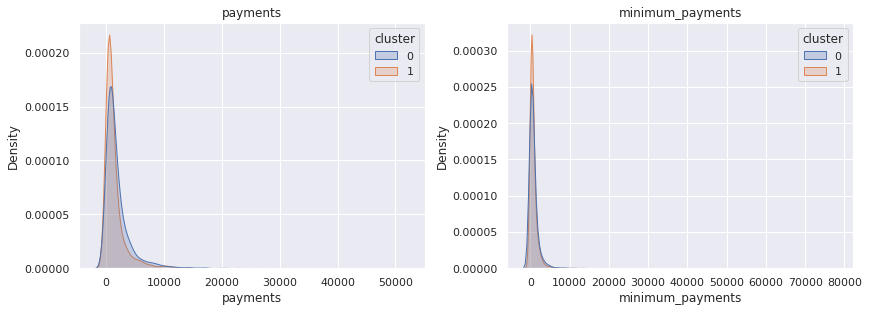

In [93]:
# plot distribution of each features
plt.figure(figsize=(18, 8))

for i, col in enumerate([col for col in X_agglo.columns.to_list() if 'payments' in col]):
    plt.subplot(2, 3, i+1)
    sns.kdeplot(X_agglo[col], shade=True, color='#0072B2', hue=X_agglo['cluster'])
    plt.title(col)

plt.tight_layout()
plt.show()

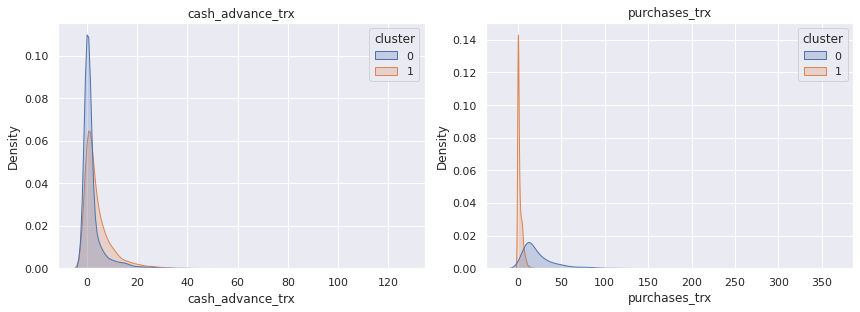

In [94]:
# plot distribution of each features
plt.figure(figsize=(18, 8))

for i, col in enumerate([col for col in X_agglo.columns.to_list() if 'trx' in col]):
    plt.subplot(2, 3, i+1)
    sns.kdeplot(X_agglo[col], shade=True, color='#0072B2', hue=X_agglo['cluster'])
    plt.title(col)

plt.tight_layout()
plt.show()

In [95]:
# display the mean of each cluster
X_agglo.groupby('cluster').mean()

balance  balance_frequency  purchases  oneoff_purchases  \
cluster                                                            
0        1451.72               0.93    1743.32            987.56   
1        1679.35               0.82     242.81            194.71   

         installments_purchases  cash_advance  purchases_frequency  \
cluster                                                              
0                        756.16        642.78                 0.86   
1                         48.16       1336.81                 0.11   

         oneoff_purchases_frequency  purchases_installments_frequency  \
cluster                                                                 
0                              0.33                              0.67   
1                              0.07                              0.05   

         cash_advance_frequency  cash_advance_trx  purchases_trx  \
cluster                                                            
0                          0.09              2.25          27.42   
1                          0.19              4.36           2.06   

         credit_limit  payments  minimum_payments  prc_full_payment  tenure  
cluster                                                                      
0             4851.92   2022.78            901.49              0.24   11.57  
1             4135.53   1451.25            824.18              0.06   11.46

In [96]:
# display the median of each cluster
X_agglo.groupby('cluster').median()

balance  balance_frequency  purchases  oneoff_purchases  \
cluster                                                            
0         601.92                1.0      924.6            291.41   
1        1075.40                1.0       35.0              0.00   

         installments_purchases  cash_advance  purchases_frequency  \
cluster                                                              
0                        431.28          0.00                 0.92   
1                          0.00        419.35                 0.08   

         oneoff_purchases_frequency  purchases_installments_frequency  \
cluster                                                                 
0                              0.17                              0.75   
1                              0.00                              0.00   

         cash_advance_frequency  cash_advance_trx  purchases_trx  \
cluster                                                            
0                           0.0               0.0           16.0   
1                           0.1               2.0            1.0   

         credit_limit  payments  minimum_payments  prc_full_payment  tenure  
cluster                                                                      
0              4000.0   1111.59            235.88               0.0    12.0  
1              3000.0    672.66            357.43               0.0    12.0

We have successfully divided the data set into 2 clusters. Observing the distribution plot, median, and mean of each clusters, we can come to a conclusion that is pretty similar as in the *K-Means* algorithm.\
However, in *Agglomerative*, the cluster size is much more equal between `cluster 0` and `cluster 1`

- `Cluster 0`
    - Purchases more frequently
    - Uses purchases installments more frequently
    - Doesn't tend to use cash advance
    - Has higher purchases amount
- `Cluster 1`
    - Purchases less frequently
    - Uses purchases installments less frequently
    - Slightly uses cash advance more frequently
    - Has lower purchases amount

This is consistent with our EDA

### Create a pipeline

In [97]:
# create a pipeline for kmeans using the best number of clusters
agglo_pipe = Pipeline([
    ('ct', ct_mm),
    ('pca', PCA(n_components=0.8, random_state=random_state)),
    ('agglo', AgglomerativeClustering(n_clusters=2))
])

# fit the pipeline to the data
agglo_pipe.fit(X)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num_norm',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['purchases_frequency']),
                                                 ('num_skew',
                                                  Pipeline(steps=[('min_max_scaler',
                                                                   MinMaxScaler())]),
                                                  ['balance',
                                                   'balance_frequency',
                                                   'purchases',
                                                   'oneoff_purchases',
                                                   'installments_purchases',
                                                   'cash_advance',
                                                   'oneoff_purchases_frequency',
                                                   'purchases_installments_frequency',
                                                   'cash_advance_frequency',
                                                   'cash_advance_trx',
                                                   'purchases_trx',
                                                   'credit_limit', 'payments',
                                                   'minimum_payments',
                                                   'prc_full_payment',
                                                   'tenure'])])),
                ('pca', PCA(n_components=0.8, random_state=42)),
                ('agglo', AgglomerativeClustering())])

## Gaussian Mixtures

In [98]:
# create a list for each gm clusters
gm_per_k = [GaussianMixture(n_components=k, random_state=random_state).fit(X_reduced)
             for k in range(1, 15)]

### BIC and AIC Score

In [99]:
# store bic scores for each gm clusters
bic_scores = [model.bic(X_reduced) for model in gm_per_k]

# store aic scores for each gm component
aic_scores = [model.aic(X_reduced) for model in gm_per_k]

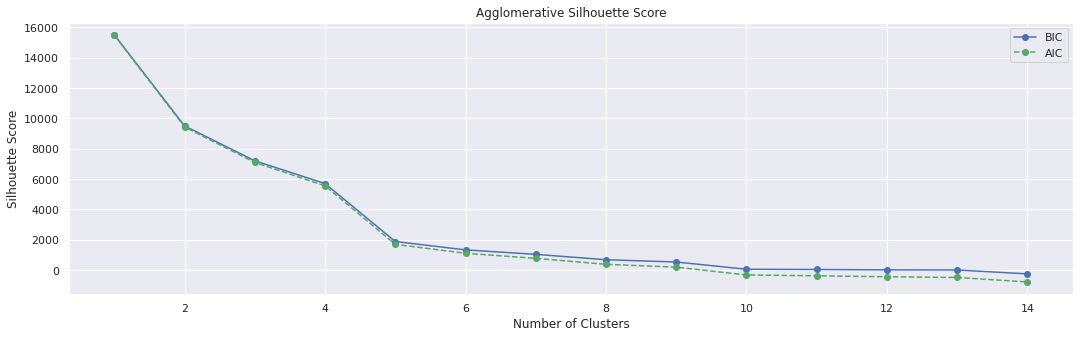

In [100]:
# plot silhouette scores for each gm clusters
plt.figure(figsize=(18, 5))
plt.plot(range(1, 15), bic_scores, 'bo-', label='BIC')
plt.plot(range(1, 15), aic_scores, 'go--', label='AIC')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Agglomerative Silhouette Score')
plt.legend()
plt.show()

In [101]:
# print the best number of clusters best on bic
print('Best number of clusters on BIC:', np.argmin(bic_scores) + 2)

# print the best number of clusters best on aic
print('Best number of clusters on AIC:', np.argmin(aic_scores) + 2)

Best number of clusters on BIC: 15
Best number of clusters on AIC: 15


Based on the BIC score, the optimal number of clusters is 14. Since this is also the highest in the range I provided before, it means I should test for a higher number.\
However, I do not plan to divide up my dataset into 14 clusters, so I'm not going to continue with this procedure.

### Plotting Decision Boundary

In [102]:
# declare gaussian mixture object with the best number of clusters from bic
gm = GaussianMixture(n_components=14, random_state=random_state)

# fitting the gaussian mixture model
gm.fit(X_reduced)

GaussianMixture(n_components=14, random_state=42)

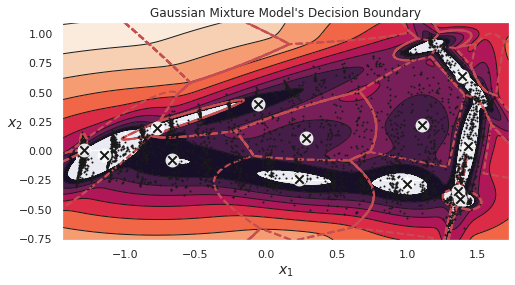

In [103]:
# plotting gaussian mixture clusters using the best number of clusters from bic
plt.figure(figsize=(8, 4))
plot_gaussian_mixture(gm, X_reduced)
plt.title('Gaussian Mixture Model\'s Decision Boundary')
plt.show()

This is how the decision boundaries would look like with the best number of clusters from bic.\
Now I want to plot to see what it would look like using 2 clusters like in *K-Means* and *Agglomerative*

In [104]:
# declare gaussian mixture object with the best number of clusters from bic
gm = GaussianMixture(n_components=2, random_state=random_state)

# fitting the gaussian mixture model
gm.fit(X_reduced)

GaussianMixture(n_components=2, random_state=42)

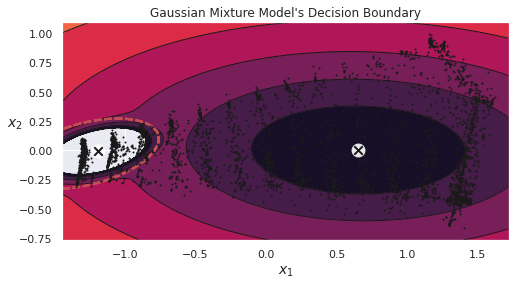

In [105]:
# plotting gaussian mixture clusters using the best number of clusters from bic
plt.figure(figsize=(8, 4))
plot_gaussian_mixture(gm, X_reduced)
plt.title('Gaussian Mixture Model\'s Decision Boundary')
plt.show()

Seem like the division for 2 clusters are also very different from *K-Means* and *Agglomerative*

I'm not going to perform the clustering for this algorithm since dividing it into 14 clusters, or maybe more since we hit the maximum, would make the clustering too complex. So I'm just going to decide my final model to be between *K-Means* and *Agglomerative*

## Save The Final Model

I've decided to stick with *K-Means* as the final model as it's more commonly used and there's not much difference between the result of *K-Means* and *Agglomerative*

In [106]:
# prepare directory for saving model
model_dir = 'models'
model_name = 'model_kmeans.pkl'

# create directory if it does not exist
Path(model_dir).mkdir(parents=True, exist_ok=True)

# save model
joblib.dump(kmeans_pipe, Path(model_dir, model_name))

['models/model_kmeans.pkl']

# 9. Model Inference

## Load The Model

In [107]:
# model location
model_dir = 'models'
model_name = 'model_kmeans.pkl'
model_path = Path(model_dir, model_name)

# load model
kmeans_model = joblib.load(model_path)

In [108]:
# display inference set
df_inf.head()

balance  balance_frequency  purchases  oneoff_purchases  \
0   605.20               1.00    1279.50             543.0   
1  1377.18               1.00       0.00               0.0   
2   101.56               1.00     418.59               0.0   
3    27.53               0.91     187.50               0.0   
4  4218.96               1.00       0.00               0.0   

   installments_purchases  cash_advance  purchases_frequency  \
0                  736.50        203.15                 1.00   
1                    0.00        173.97                 0.00   
2                  418.59          0.00                 0.83   
3                  187.50          0.00                 0.50   
4                    0.00       4734.30                 0.00   

   oneoff_purchases_frequency  purchases_installments_frequency  \
0                        0.38                              0.88   
1                        0.00                              0.00   
2                        0.00                              0.50   
3                        0.00                              0.42   
4                        0.00                              0.00   

   cash_advance_frequency  cash_advance_trx  purchases_trx  credit_limit  \
0                    0.25                 5             37        1000.0   
1                    0.50                 7              0        1500.0   
2                    0.00                 0              5        1000.0   
3                    0.00                 0              6        2000.0   
4                    0.58                44              0        4500.0   

   payments  minimum_payments  prc_full_payment  tenure  
0    661.34            142.60              0.14       8  
1    366.25            451.84              0.00      12  
2    422.54             81.39              0.50       6  
3    280.02            137.47              0.33      12  
4   5557.54           1434.24              0.08      12

## Inferencing

In [109]:
%%time

# predict inference set using the final model
inf_cluster = kmeans_model.predict(df_inf)

CPU times: user 23.2 ms, sys: 0 ns, total: 23.2 ms
Wall time: 18.4 ms


In [110]:
# create dataframe with predictions
df_inf['cluster'] = inf_cluster

# display inference set
df_inf

balance  balance_frequency  purchases  oneoff_purchases  \
0   605.20               1.00    1279.50            543.00   
1  1377.18               1.00       0.00              0.00   
2   101.56               1.00     418.59              0.00   
3    27.53               0.91     187.50              0.00   
4  4218.96               1.00       0.00              0.00   
5   625.14               1.00     958.39            365.00   
6   173.33               1.00    1301.44            916.80   
7  5238.92               1.00     270.00            270.00   
8    24.82               0.91     390.05             44.90   
9   236.26               1.00    1949.62           1430.92   

   installments_purchases  cash_advance  purchases_frequency  \
0                  736.50        203.15                 1.00   
1                    0.00        173.97                 0.00   
2                  418.59          0.00                 0.83   
3                  187.50          0.00                 0.50   
4                    0.00       4734.30                 0.00   
5                  593.39          0.00                 1.00   
6                  384.64          0.00                 0.92   
7                    0.00       2706.55                 0.17   
8                  345.15          0.00                 0.83   
9                  518.70          0.00                 1.00   

   oneoff_purchases_frequency  purchases_installments_frequency  \
0                        0.38                              0.88   
1                        0.00                              0.00   
2                        0.00                              0.50   
3                        0.00                              0.42   
4                        0.00                              0.00   
5                        0.17                              1.00   
6                        0.58                              0.75   
7                        0.17                              0.00   
8                        0.08                              0.75   
9                        1.00                              0.50   

   cash_advance_frequency  cash_advance_trx  purchases_trx  credit_limit  \
0                    0.25                 5             37        1000.0   
1                    0.50                 7              0        1500.0   
2                    0.00                 0              5        1000.0   
3                    0.00                 0              6        2000.0   
4                    0.58                44              0        4500.0   
5                    0.00                 0             30        4000.0   
6                    0.00                 0             25        4000.0   
7                    0.67                14              3        6000.0   
8                    0.00                 0             11        1000.0   
9                    0.00                 0             38        1800.0   

   payments  minimum_payments  prc_full_payment  tenure  cluster  
0    661.34            142.60              0.14       8        0  
1    366.25            451.84              0.00      12        1  
2    422.54             81.39              0.50       6        0  
3    280.02            137.47              0.33      12        1  
4   5557.54           1434.24              0.08      12        1  
5    881.16            205.20              0.00      12        0  
6    954.99            185.62              0.30      12        0  
7   1259.20           1197.40              0.00      12        1  
8    423.34            117.84              0.27      12        0  
9   1679.27            163.82              0.10      12        0

Model successfully run on inference dataset

# 10. Conclusion

## On EDA
- `balance`, `cash_advance`, and `credit_limit` are skewed distributions. They also seem to have a lot of outliers.
- Observing the `purchases_frequency` feature, the distribution is actually separated between the left side and the right side, which means most customers are either use it frequently, or rarely use it.
- Amongst those who frequently use it, most common usage is, in order of frequency, for installments purchases, then oneoff purchases, then cash advances
- Most people purchase in small amounts
- Most customers make payments in small amounts
- Most of the tenure is centered around 12 months. This makes sense as most people might want to opt for the longest options for their installment
- There are weird entries where the combined amount of `oneoff_purchases` and `installments_purchases` exceed that of `purchases`. This is weird, considering `purchases`, by definition, is supposed to be `oneoff_purchases` + `installments_purchases`
- We can't answer this finding as of yet. We would need to further look into it using information from outside the dataset. Was there an error in entry? Is there any method of calculating the variables that we do not know yet? These are good questions to be explored

## On Modeling
- Calculating variance inflation factor to check multicollinearity shows that we can reduce our dataset into 9 features
- However, running the PCA on only 2 components already reached 80% of cumulative EVR, which is good enough, hence I decided to use 2 components
- K-Means and Agglomerative in this research produced similar outcome of clustering the dataset into two
- One cluster for those who frequently uses the credit card and the another for those who rarely uses it
- Gaussian Mixtures however, recommended that we divide the dataset into 14 (and probably more) clusters
- I find that this is too excessive and might cluster our dataset with too much specificity

## Implication
- Using this clustering algorithm, we can now understand our customer segmentation even more
- We could create specific strategies for those who have yet to frequently use their credit cards, so we can increase their usage
- On the other hand, we can create a different targeted marketing strategy for those that have already used the credit card frequently

## Future Improvement
- We could try to increase the dimensions used to see how it would resulted to
- We could also try to divide up into more clusters as there were a couple promising ones as well in *K-Means* and *Agglomerative*
- We could also tweak the parameter on Gaussian Mixtures to produce a different results, or try running the number of clusters suggested, in which we have to further expand our list